In [1]:
%pip install tensorflow==2.15.0


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Install TensorFlow Quantum:

In [2]:
%pip install tensorflow-quantum==0.7.3

ERROR: Could not find a version that satisfies the requirement tensorflow-quantum==0.7.3 (from versions: none)
ERROR: No matching distribution found for tensorflow-quantum==0.7.3
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Update package resources to account for version changes.
import importlib, pkg_resources
importlib.reload(pkg_resources)

<module 'pkg_resources' from '/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py'>

Now import TensorFlow and the module dependencies:

In [ ]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, wasserstein_distance, probplot
from scipy.special import lambertw
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
import time
import cirq, random, sympy
import tensorflow_quantum as tfq
import tensorflow as tf
from cirq.contrib.svg import SVGCircuit
from cirq.circuits import InsertStrategy
import pandas as pd

In [ ]:
# Load the CSV file
#file_path = 'real.csv'
lucy = pd.read_csv('lucy2.csv', parse_dates=True)
window = 4

lucy['OD'] = lucy['OD'].fillna(lucy['OD'].rolling(window=40, min_periods=10).mean())
lucy['DATE']= pd.to_datetime(lucy['DATE'], format= 'mixed')
for i in range(len(lucy['DATE'])):
    if lucy['DATE'][i].month ==1:
        lucy.loc[i,'DATE']= lucy['DATE'][i].replace(month=4)
        lucy.loc[i,'DATE']= lucy['DATE'][i].replace(day=1)
lucy.head()


,DATE,PRE,TEMP EXT,TEMP_CULTURE,PAR_LIGHT,PH,DO,OD,DRY,CELL
0,2024-03-27 13:12:00,118.75,20.7,27.0,12.5,8.80,23.57,0.55,0.191455,281000000.0
1,2024-03-27 13:22:00,118.75,20.7,27.4,12.5,8.83,23.57,0.58,0.201898,297000000.0
2,2024-03-27 13:32:00,118.75,20.7,27.8,12.5,7.19,23.35,0.62,0.215822,317000000.0
3,2024-03-27 13:42:00,118.75,20.7,28.1,12.5,7.01,23.87,0.64,0.222784,327000000.0
4,2024-03-27 13:52:00,118.75,20.7,27.9,12.5,7.20,23.96,0.66,0.229746,337000000.0


Lucy shape (total days):  tf.Tensor([778], shape=(1,), dtype=int32)
GPU Available: []
GPU Device: 


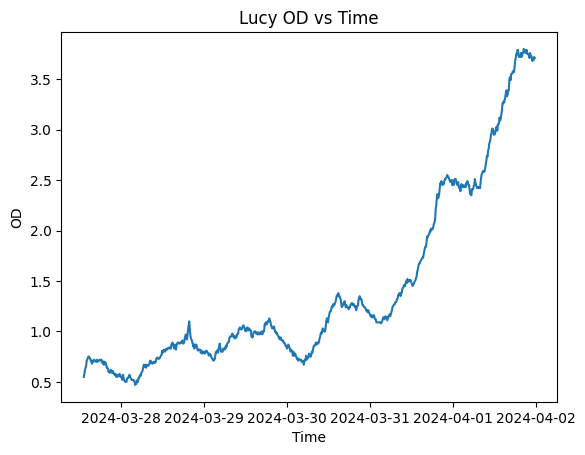

In [ ]:
# pandas DataFrame with 6 columns, (Open, High, Low, Close, Adj Close, and Volume values)
# extract daily closing values as a numpy array
OD = tf.convert_to_tensor(lucy['OD'].values)

# display the shape of the numpy array
print('Lucy shape (total days): ', tf.shape(OD))

# check if GPU is available
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# check which GPU is being used
print("GPU Device:", tf.test.gpu_device_name())

df = lucy.reset_index()
date = df['DATE']
# plot the Lucy OD data
plt.plot(date, OD)
plt.xlabel('Time')
plt.ylabel('OD')
plt.title('Lucy OD vs Time')
#plt.grid()
plt.show()

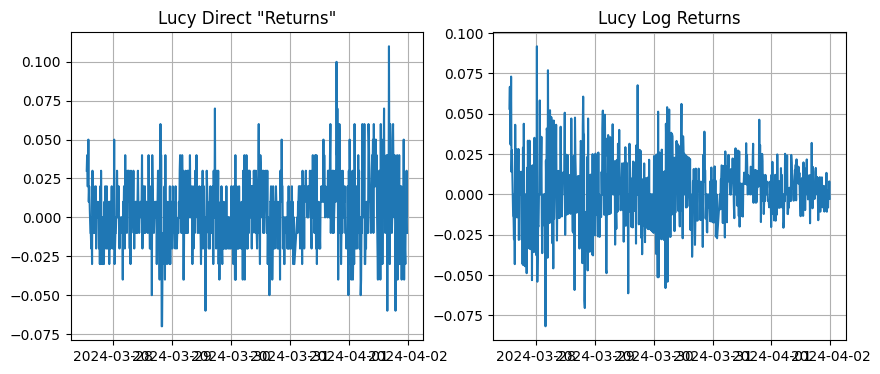

In [ ]:
# direct returns over time
lucy_returns = OD[1:] - OD[:-1]

# logarithmic returns over time
lucy_log_returns = np.log(OD[1:]) - np.log(OD[:-1])

# plot the graphs side-by-side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

axes[0].plot(date[1:], lucy_returns)
axes[0].set_title('Lucy Direct "Returns"')
axes[0].grid()

axes[1].plot(date[1:], lucy_log_returns)
axes[1].set_title('Lucy Log Returns')
axes[1].grid()

# Show the plot
plt.show()

In [ ]:
df = pd.DataFrame(lucy_log_returns)

# Save the DataFrame to a CSV file
csv_filename = 'original_lucy_log_returns.csv'
df.to_csv(csv_filename, index=False)

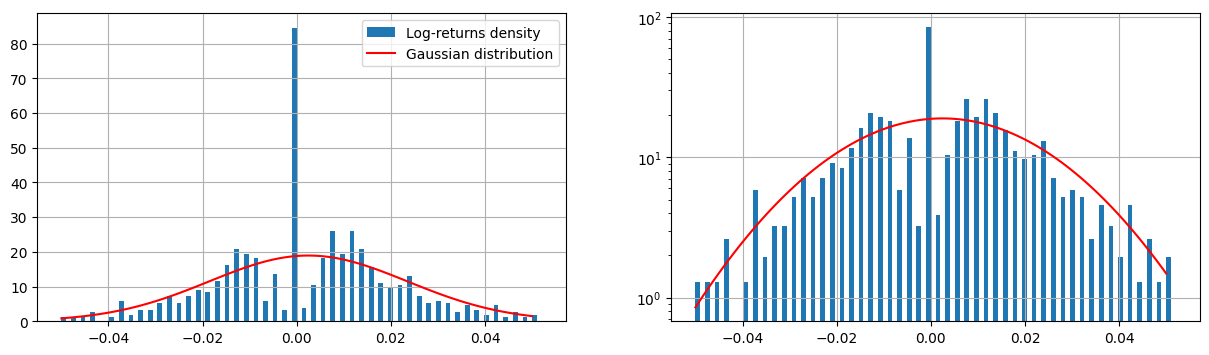

In [ ]:
# plot the graphs side-by-side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))

# density of log-returns
bin_edges = np.linspace(-0.05, 0.05, num=50)  # define the bin edges
bin_width = bin_edges[1] - bin_edges[0]
bin_edges = np.append(bin_edges, bin_edges[-1] + bin_width)
axes[0].hist(lucy_log_returns, bins=bin_edges, density=True, width=0.001, label='Log-returns density')
axes[0].grid()

# normal distribution with same mean and standard deviation as log-returns
mu = np.mean(lucy_log_returns)
sigma = np.std(lucy_log_returns)

# Generate a set of points x
x = np.linspace(-0.05, 0.05, 100)

# Generate the Gaussian PDF for the points x with same mean and standard deviation as the log-returns
pdf = norm.pdf(x, mu, sigma)

# plot the Gaussian PDF
axes[0].plot(x, pdf, 'r', label='Gaussian distribution')
axes[0].legend()

# plot in logarithmic scale
axes[1].hist(lucy_log_returns, bins=bin_edges, density=True, width=0.001, log=True)
axes[1].grid()

# plot the Gaussian PDF in logarithmic scale
axes[1].semilogy(x, pdf, 'r')

plt.show()

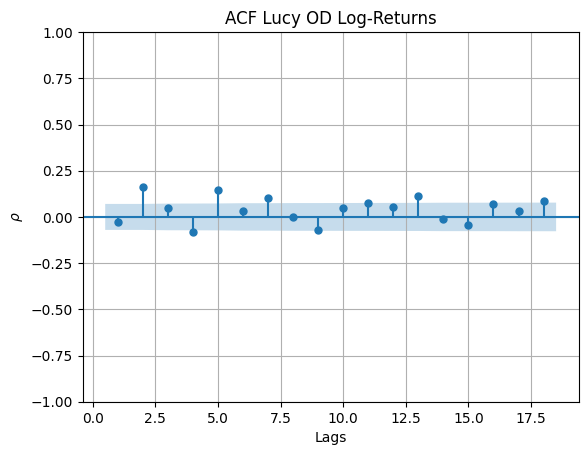

In [ ]:
# convert the S&P 500 log returns to a TensorFlow tensor
lucy_log_r_tf = tf.convert_to_tensor(lucy_log_returns)
# plot the ACF for the specified lags
tsaplots.plot_acf(lucy_log_r_tf, lags=18, zero=False)
plt.xlabel('Lags')
plt.title('ACF Lucy OD Log-Returns')
plt.ylabel(r'$\rho$')
plt.grid()
plt.show()

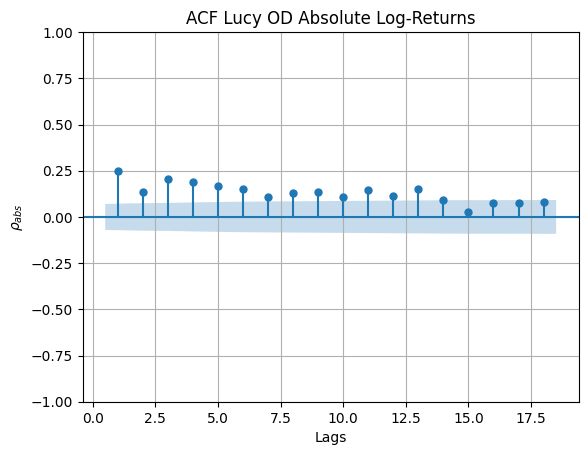

In [ ]:
# plot the ACF of absolute log-returns for the specified lags
tsaplots.plot_acf(tf.abs(lucy_log_r_tf), lags=18, zero=False)
plt.xlabel('Lags')
plt.title('ACF Lucy OD Absolute Log-Returns')
plt.ylabel(r'$\rho_{abs}$')
plt.grid()
plt.show()

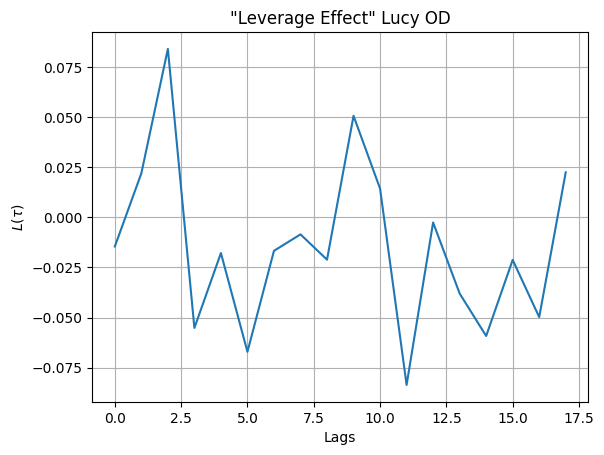

In [ ]:
lags = range(1, 19)
lev = []
for lag in lags:
    # slice the tensors to get the appropriate lagged sequences
    r_t = lucy_log_r_tf[:-lag]
    squared_lag_r = tf.square(tf.abs(lucy_log_r_tf[lag:]))

    # calculate the leverage effect
    # calculate the correlation coefficient
    correlation_matrix = np.corrcoef(r_t, squared_lag_r)
    lev.append(correlation_matrix[0, 1])

# plot the the levarage effect
plt.plot(lev)
plt.title('"Leverage Effect" Lucy OD')
plt.xlabel('Lags')
plt.ylabel(r'$L(\tau)$')
plt.grid()
plt.show()

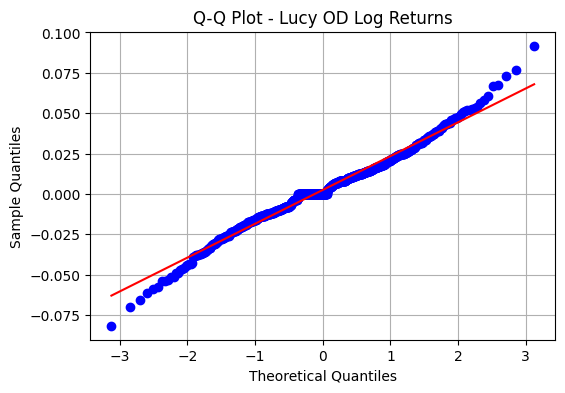

In [ ]:
# Generate the Q-Q plot
plt.figure(figsize=(6, 4))
probplot(lucy_log_r_tf, dist='norm', plot=plt)
plt.title('Q-Q Plot - Lucy OD Log Returns')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid(True)
plt.show()

In [ ]:
def normalize(data):
    mu = tf.reduce_mean(data)
    std = tf.math.reduce_std(data)

    return (data - mu)/std

In [ ]:
def denormalize(norm_data, mu_original, std_original):
    return norm_data*std_original + mu_original

In [ ]:
# normalize the log-returns
lucy_norm_r = normalize(lucy_log_r_tf)
# display the mean and standard deviation of the original log-returns
print(f'Original Lucy OD log-returns mean = {tf.reduce_mean(lucy_log_r_tf)}, std = {tf.math.reduce_std(lucy_log_r_tf)}')
# display the mean and standard deviation of the normalized log-returns
print(f'Normalized Lucy OD log-returns mean = {tf.reduce_mean(lucy_norm_r)}, std = {tf.math.reduce_std(lucy_norm_r)}')

Original Lucy OD log-returns mean = 0.002456716701898281, std = 0.021068542364353737
Normalized Lucy OD log-returns mean = 5.686856676973132e-17, std = 1.0


Original Data Min-Max
-0.08167803101426718 0.09180754925312262
Normalized Data Min-Max
-3.9933824685714674 4.24095938893232


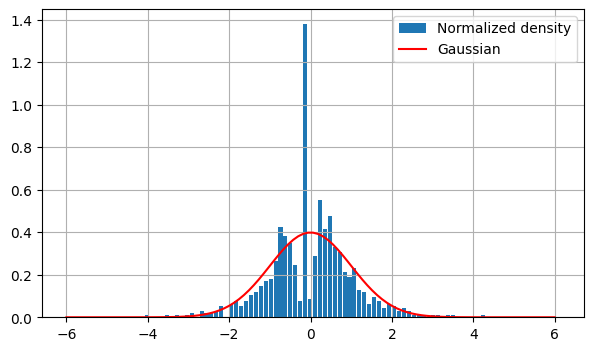

In [ ]:
print('Original Data Min-Max')
print(tf.reduce_min(lucy_log_r_tf).numpy(), tf.reduce_max(lucy_log_r_tf).numpy())

print('Normalized Data Min-Max')
print(tf.reduce_min(lucy_norm_r).numpy(), tf.reduce_max(lucy_norm_r).numpy())

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7,4))

# density of log-returns
bin_edges = np.linspace(-6, 6, num=100)  # define the bin edges
bin_width = bin_edges[1] - bin_edges[0]
bin_edges = np.append(bin_edges, bin_edges[-1] + bin_width)
axes.hist(lucy_norm_r, bins=bin_edges, density=True, width=0.1, label='Normalized density')
axes.grid()

# normal distribution with same mean and standard deviation as log-returns
mu = np.mean(lucy_norm_r)
sigma = np.std(lucy_norm_r)

# Generate a set of points x
x = np.linspace(-6, 6, 100)

# Generate the Gaussian PDF for the points x with same mean and standard deviation as the log-returns
pdf = norm.pdf(x, mu, sigma)

# plot the Gaussian PDF
axes.plot(x, pdf, 'r', label='Gaussian')
axes.legend()

plt.show()

In [ ]:
def inverse_lambert_w_transform(data, delta):
    """
    Apply inverse Lambert W transform to the input data using the specified delta value.

    Parameters:
    - data: Input data tensor
    - delta: Delta value for the transform (tail parameter)

    Returns:
    - Transformed data array
    """
    sign = tf.sign(tf.cast(data, dtype=tf.float64))
    transformed_data = sign * tf.cast(tf.sqrt(lambertw(delta * data ** 2).real / delta), dtype=tf.float64)

    return transformed_data

def lambert_w_transform(transformed_data, delta, clip_low=-12.0, clip_high=11.0):
    """
    Transform the Gaussianized data back to its original state.

    Parameters:
    - transformed_data: Input data array which was transformed using inverse Lambert W
    - delta: Delta value for the transform (tail parameter)

    Returns:
    - Original Data
    """
    reversed_data = transformed_data*tf.cast(tf.exp((delta/2) * transformed_data ** 2), dtype=tf.float64)
    return tf.clip_by_value(reversed_data, clip_low, clip_high)

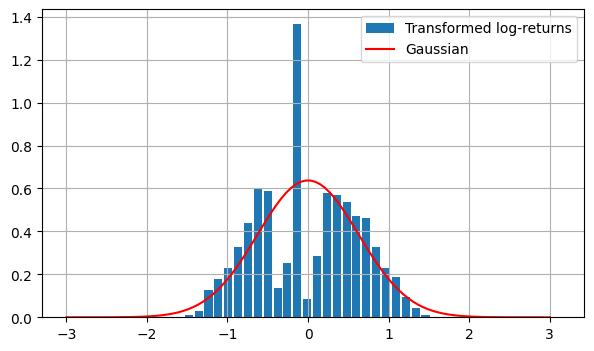

In [ ]:
# apply inverse Lambert W transform to the normalized log-returns
delta = 1
transformed_lucy_OD = inverse_lambert_w_transform(lucy_norm_r, delta)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7,4))

# density of normalized log-returns
bin_edges = np.linspace(-3, 3, num=50)  # define the bin edges
bin_width = bin_edges[1] - bin_edges[0]
bin_edges = np.append(bin_edges, bin_edges[-1] + bin_width)
axes.hist(transformed_lucy_OD, bins=bin_edges, density=True, width=0.1, label='Transformed log-returns')
axes.grid()

# normal distribution with same mean and standard deviation as log-returns
mu = np.mean(transformed_lucy_OD)
sigma = np.std(transformed_lucy_OD)

# Generate a set of points x
x = np.linspace(-3, 3, 100)

# Generate the Gaussian PDF for the points x with same mean and standard deviation as the normalized log-returns
pdf = norm.pdf(x, mu, sigma)

# plot the Gaussian PDF
axes.plot(x, pdf, 'r', label='Gaussian')
axes.legend()

plt.show()

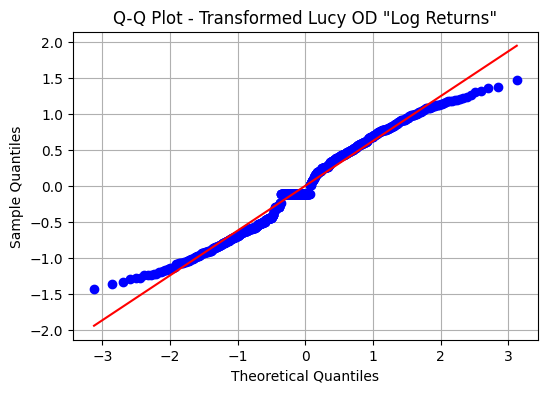

In [ ]:
# Generate the Q-Q plot
plt.figure(figsize=(6, 4))
probplot(transformed_lucy_OD, dist='norm', plot=plt)
plt.title('Q-Q Plot - Transformed Lucy OD "Log Returns"')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid(True)
plt.show()

In [ ]:
print('Transformed Data Min-Max')
print(tf.reduce_min(transformed_lucy_OD).numpy(), tf.reduce_max(transformed_lucy_OD).numpy())

Transformed Data Min-Max
-1.4321194823237178 1.4602578456477353


In [ ]:
min_val = tf.reduce_min(transformed_lucy_OD)
max_val = tf.reduce_max(transformed_lucy_OD)
scaled_data = -1.0 + 2.0 * (transformed_lucy_OD - min_val) / (max_val - min_val)

In [ ]:
print(f'Scaled Normalized Transformed log-returns mean = {tf.reduce_mean(scaled_data)}, std = {tf.math.reduce_std(scaled_data)}')
print('Scaled Normalized Transformed log-returns min-max: ', tf.reduce_min(scaled_data).numpy(), tf.reduce_max(scaled_data).numpy())

Scaled Normalized Transformed log-returns mean = -0.009253192035731439, std = 0.43256905488958786
Scaled Normalized Transformed log-returns min-max:  -1.0 1.0


In [ ]:
# a function to scale back from [-1,1] to the previous range
def rescale(scaled_data, rescaled_data):
    min_val = tf.reduce_min(rescaled_data)
    previous_data = 0.5 * (scaled_data + 1.0) * (max_val - min_val) + min_val

    return previous_data

In [ ]:
def rolling_window(data, m, s):
    return tf.map_fn(lambda i: data[i:i+m], tf.range(0, len(data) - m + 1, s), dtype=tf.float64)

In [ ]:
#1parte
class qGAN(tf.keras.Model):
    def __init__(self, num_epochs, batch_size, window_length, n_critic, gp, num_layers, num_qubits):
        super(qGAN, self).__init__()

        # classical hyperparameters
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.window_length = window_length
        self.n_critic = n_critic
        self.gp = gp

        # quantum hyperparameters
        # one layer corresponds to a rotation and an entangling layer together
        self.num_layers = num_layers
        self.num_qubits = num_qubits

        # quantum circuit settings
        self.qubits = cirq.GridQubit.rect(1, num_qubits)
        # create the set of Pauli strings to measure -> {X1, Z1, X2, Z2, etc}
        # X1 means we measure the first qubit only with X, Z1 the first qubit only with Z and so on...
        self.measurements = []
        for qubit in self.qubits:
            self.measurements.append(cirq.X(qubit))
            self.measurements.append(cirq.Z(qubit))

        # number of parameters of the PQC and re-uploading layers
        self.num_params = self.count_params()

        # define the trainable parameters of the PQC main and re-uploading layers (trainable)
        self.params_pqc = [sympy.Symbol(f'theta{i}') for i in range(self.num_params)]

        # define the classical critic network (CNN)
        self.critic = self.define_critic_model(window_length)
        # define the quantum generator network (PQC)
        self.generator = self.define_generator_model()

        # monitoring purposes
        # average critic and generator losses for each epoch
        self.critic_loss_avg = []
        self.generator_loss_avg = []
        # Earth's mover distance (EMD) for each epoch
        self.emd_avg = []
        # stylized facts RMSEs for each epoch
        self.acf_avg = []
        self.vol_avg = []
        self.lev_avg = []
#2 parte
    ####################################################################################
    #
    # count the parameters of the quantum circuit
    #
    ####################################################################################
    def count_params(self):

        # rotation layer with Rx, Ry, Rz has 3N parameters, where N is the number of qubits
        # the entangling layer is not parameterized
        num_params_pqc = 3*self.num_qubits*self.num_layers

        # also, count the parameters of the re-uploading layer that is sandwiched between rotation-entangling layers
        # there is one re-uploading layer after each rotation-entangling layer with a parameterized Rx gate,
        # so the number of parameters is equal to the number of qubits for each re-uploading layer
        num_params_upload = self.num_layers*self.num_qubits

        # the last layer of the PQC is a rotation layer
        num_params_pqc += 3*self.num_qubits

        return num_params_pqc+num_params_upload

    ####################################################################################
    #
    # the classical critic model as a convolutional network
    #
    ####################################################################################
    def define_critic_model(self, window_length):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=10, strides=1, input_shape=(window_length, 1), padding='same'))
        model.add(tf.keras.layers.LeakyReLU(alpha=0.1))

        model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=10, strides=1, padding='same'))
        model.add(tf.keras.layers.LeakyReLU(alpha=0.1))

        model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=10, strides=1, padding='same'))
        model.add(tf.keras.layers.LeakyReLU(alpha=0.1))

        model.add(tf.keras.layers.Flatten())

        model.add(tf.keras.layers.Dense(32, dtype=tf.float64))
        model.add(tf.keras.layers.LeakyReLU(alpha=0.1))
        model.add(tf.keras.layers.Dropout(0.2))

        model.add(tf.keras.layers.Dense(1, dtype=tf.float64))

        return model

    ####################################################################################
    #
    # the encoding layer: resolve the parameters by uniform noise values,
    # used to prepare the initial state for the generator circuit
    #
    ####################################################################################
    def encoding_layer(self, noise_params):

        return cirq.Circuit(cirq.Rx(rads=noise_params[i])(self.qubits[i]) for i in range(self.num_qubits))

    ####################################################################################
    #
    # the quantum generator as a PQC with All-to-all topology for the entangling layer
    #
    ####################################################################################
    def define_generator_circuit(self):

        # cirq circuit
        pqc = cirq.Circuit()

        # index for the parameter tensor of the PQC main and re-uploading layers
        idx = 0
        for qubit in self.qubits:
            pqc.append(cirq.H(qubit))
        for layer in range(self.num_layers):
            ###############################################################
            #
            # single-qubit rotation layer
            #
            ###############################################################
            for qubit in self.qubits:
                ####################CAMBIO####################
                pqc.append(cirq.Rx(rads=self.params_pqc[idx])(qubit))
                idx += 1
                pqc.append(cirq.Ry(rads=self.params_pqc[idx])(qubit))
                idx += 1
                #pqc.append(cirq.Rz(rads=self.params_pqc[idx])(qubit))
                #idx += 1

            ###############################################################
            #
            # entangling layer (not parameterized)
            #
            ###############################################################
            for qubit1 in range(self.num_qubits):
                for qubit2 in range(qubit1+1, self.num_qubits):
                    pqc.append(cirq.CNOT(self.qubits[qubit1], self.qubits[qubit2]), strategy=InsertStrategy.NEW)

            ###############################################################
            #
            # re-uploading layer with Rx rotation
            # (set the strategy for better readability and understanding)
            #
            ###############################################################
            for i, qubit in enumerate(self.qubits):
                if i == 0:
                    pqc.append(cirq.Rx(rads=self.params_pqc[idx])(qubit), strategy=InsertStrategy.NEW)
                else:
                    pqc.append(cirq.Rx(rads=self.params_pqc[idx])(qubit), strategy=InsertStrategy.INLINE)

                idx += 1

        #####################################################################
        #
        # single-qubit rotation layer as the last layer before measurement
        #
        #####################################################################
        for qubit in self.qubits:
                pqc.append(cirq.Rx(rads=self.params_pqc[idx])(qubit))
                idx += 1
                pqc.append(cirq.Ry(rads=self.params_pqc[idx])(qubit))
                idx += 1
                #pqc.append(cirq.Rz(rads=self.params_pqc[idx])(qubit))
                #idx += 1

        return pqc

    ####################################################################################
    #
    # the quantum generator model
    #
    ####################################################################################
    def define_generator_model(self):
        # model input
        q_data_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
        # define the tensorflow quantum layer (trainable)
        generator = tfq.layers.PQC(self.define_generator_circuit(), self.measurements, repetitions=1000)
        generator_output = generator(q_data_input)
        # tensorflow model
        model = tf.keras.Model(inputs=q_data_input, outputs=generator_output)

        return model

    #############################################################################
    #
    # compile model with given optimizers for critic and generator networks
    #
    #############################################################################
    def compile_QGAN(self, c_optimizer, g_optimizer):
        super(qGAN, self).compile()
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer

    def train_qgan(self, gan_data, original_data, preprocessed_data, num_elements):
        """
        Parameters:
         - gan_data is the preprocessed dataset with windows for qGAN training
         - original_data is the original S&P 500 log-returns for evaluation of RMSEs (monitoring purposes)
         - preprocessed_data is the preprocessed log-returns without the last normalization step and without windows
          (for reversing the process of generated samples using the mean and std and evaluating the RMSEs)
        """
        # Convert DataLoader to list for random sampling (PyTorch approach)
        gan_data_list = []
        for batch in gan_data:
            for sample in batch[0]:  # batch[0] contains the data
                gan_data_list.append(sample)

        for epoch in range(self.num_epochs):
            print(f'Processing epoch {epoch+1}/{self.num_epochs}')
            ################################################################
            #
            # Train the critic for n_critic iterations
            # Process 'batch_size' samples in each iteration
            #
            ################################################################
            # critic loss for 'n_critic' iterations
            critic_t_sum = 0
            for t in range(self.n_critic):
                # record the gradients
                with tf.GradientTape() as critic_tape:
                    # critic loss for 'batch_size' samples
                    critic_sum = 0
                    for i in range(self.batch_size):
                        ###########################################
                        #
                        # Sample real data and a latent variable
                        #
                        ###########################################
                        # shuffle the dataset
                        shuffled_data = gan_data.shuffle(buffer_size=num_elements)
                        # take a single random element from the shuffled dataset
                        random_element = shuffled_data.take(1)
                        # iterate over the random_element dataset to access the value
                        for element in random_element:
                            # access the value of the random element as a tensor
                            real_sample = element
                        # reshape the real sample for compatibility with the first layer of the critic
                        real_sample = tf.reshape(real_sample, (1, self.window_length))

                        ##################################################
                        #
                        # Get the state prepared by the encoding circuit
                        #
                        ##################################################
                        # generate noise parameters for the encoding layer
                        noise_values = np.random.uniform(0, 2 * np.pi, size=self.num_qubits)
                        generator_input_state = self.encoding_layer(noise_values)
                        # convert to tensorflow quantum tensor
                        generator_input = tfq.convert_to_tensor([generator_input_state])
                        # get the fake sample as the expectations of the quantum circuit
                        generated_sample = self.generator(generator_input)
                        generated_sample = tf.cast(generated_sample, dtype=tf.float64)

                        # calculate the critic scores for real and fake samples
                        real_score = self.critic(real_sample)
                        fake_score = self.critic(generated_sample)

                        # compute the gradient penalty
                        gradient_penalty = self.compute_gradient_penalty(real_sample, generated_sample)

                        # calculate the Wasserstein distance loss with gradient penalty
                        critic_loss = fake_score - real_score + self.gp * gradient_penalty
                        # accumulate the critic loss for the sample
                        critic_sum += critic_loss

                    # compute the gradients of critic and apply them
                    critic_gradients = critic_tape.gradient(critic_sum/self.batch_size, self.critic.trainable_variables)
                    self.c_optimizer.apply_gradients(zip(critic_gradients, self.critic.trainable_variables))

                    # accumulate the average critic loss for all samples in this 't' iteration
                    critic_t_sum += critic_sum/self.batch_size

            # average critic loss for this epoch of WGAN training
            self.critic_loss_avg.append(critic_t_sum/self.n_critic)

            ################################################################
            #
            # Train generator for one iteration
            #
            ################################################################
            # sample a batch of input states using the encoding layer
            input_circuits_batch = []
            for _ in range(self.batch_size):
                noise_values = np.random.uniform(0, 2 * np.pi, size=self.num_qubits)
                input_circuits_batch.append(self.encoding_layer(noise_values))

            # convert to tensorflow quantum tensor
            generator_inputs = tfq.convert_to_tensor(input_circuits_batch)

            with tf.GradientTape() as gen_tape:
                # generate fake samples using the generator
                generated_samples = self.generator(generator_inputs)
                generated_samples = tf.cast(generated_samples, dtype=tf.float64)
                # calculate the critic scores for fake samples
                fake_scores = self.critic(generated_samples)
                # calculate the generator loss
                generator_loss = -tf.reduce_mean(fake_scores)

            # compute the gradients of generator and apply them
            generator_gradients = gen_tape.gradient(generator_loss, self.generator.trainable_variables)
            self.g_optimizer.apply_gradients(zip(generator_gradients, self.generator.trainable_variables))

            # average generator loss for this epoch
            self.generator_loss_avg.append(generator_loss)

            ########################################################################################################
            #
            # Calculate the stylized facts RMSEs and the EMD for real and fake data
            #
            # Fake data has shape (num_samples x window_length), with num_samples = original_length / window_length
            # in order to get a time series close to the length of the original
            #
            ########################################################################################################
            # generate noise
            num_samples = len(original_data) // self.window_length
            input_circuits_batch = []
            for _ in range(num_samples):
                noise_values = np.random.uniform(0, 2 * np.pi, size=self.num_qubits)
                input_circuits_batch.append(self.encoding_layer(noise_values))

            # convert to tensorflow quantum tensor
            generator_inputs = tfq.convert_to_tensor(input_circuits_batch)
            # generate fake samples using the generator
            batch_generated = self.generator(generator_inputs)
            # concatenate all time series data into one
            generated_data = tf.reshape(batch_generated, shape=(num_samples*self.window_length,))
            generated_data = tf.cast(generated_data, dtype=tf.float64)
            # rescale
            generated_data = rescale(generated_data, preprocessed_data)
            # reverse the preprocessing on generated sample
            original_norm = lambert_w_transform(generated_data, delta)
            fake_original = denormalize(original_norm, tf.reduce_mean(original_data), tf.math.reduce_std(original_data))
            # calculate the temporal metrics for monitoring the training process
            corr_rmse, volatility_rmse, lev_rmse, emd = self.stylized_facts(original_data, fake_original)
            # store the EMD and RMSEs of stylized facts
            self.acf_avg.append(corr_rmse)
            self.vol_avg.append(volatility_rmse)
            self.lev_avg.append(lev_rmse)
            self.emd_avg.append(emd)

            # print progress every 100 epochs
            if epoch % 100 == 0 or epoch+1 == 3000:
                print(f'\nEpoch {epoch+1} completed')
                print(f'Critic loss (average): {self.critic_loss_avg[epoch][-1][0]}')
                print(f'Generator loss (average): {self.generator_loss_avg[epoch]}')
                print(f'\nEMD (average): {self.emd_avg[epoch]}')
                print(f'ACF RMSE (average): {self.acf_avg[epoch]}')
                print(f'VOLATILITY RMSE (average): {self.vol_avg[epoch]}')
                print(f'LEVERAGE RMSE (average): {self.lev_avg[epoch]}\n')
                print('Min-Max values of original log-returns: ', tf.reduce_min(original_data).numpy(), tf.reduce_max(original_data).numpy())
                print('Min-Max values of generated log-returns (for all batches): ', tf.reduce_min(fake_original).numpy(), tf.reduce_max(fake_original).numpy())
                print('Min-Max values after Lambert: ', tf.reduce_min(original_norm).numpy(), tf.reduce_max(original_norm).numpy())
                print()

    ###########################################################
    #
    # Sample a random number epsilon ~ U[0,1]
    # Create a convex combination of real and generated sample
    # Compute the gradient penalty for the critic network
    #
    ###########################################################
    def compute_gradient_penalty(self, real_sample, generated_sample):
        epsilon = tf.random.uniform((), dtype=tf.float64)
        interpolated_sample = epsilon * real_sample + (1 - epsilon) * generated_sample

        with tf.GradientTape() as tape:
            tape.watch(interpolated_sample)
            scores = self.critic(interpolated_sample)

        gradients = tape.gradient(scores, interpolated_sample)
        gradients_norm = tf.norm(gradients)
        gradient_penalty = (gradients_norm - 1)**2

        return gradient_penalty

    def stylized_facts(self, original_data, fake_original):
        """
        - Calculate the RMSEs of the stylized facts between the original S&P 500 log-returns and
          generated time series

        - Evaluate the EMD between real and generated samples
        """

        ################################################
        #
        # stylized facts for fake samples
        #
        ################################################
        # compute acf for maximum lags = 18
        acf_values = sm.tsa.acf(fake_original, nlags=18)
        # exclude zero lag
        acf_values_generated = tf.convert_to_tensor(acf_values[1:])

        # compute absolute acf (volatility clustering) for maximum lags = 18
        acf_abs_values = sm.tsa.acf(tf.abs(fake_original), nlags=18)
        # exclude zero lag
        acf_abs_values_generated = tf.convert_to_tensor(acf_abs_values[1:])

        # compute leverage effect for maximum lags = 18
        lev = []
        for lag in range(1, 19):
            # slice the tensors to get the appropriate lagged sequences
            r_t = fake_original[:-lag]
            squared_lag_r = tf.square(tf.abs(fake_original[lag:]))

            # calculate the leverage effect
            # calculate the correlation coefficient
            correlation_matrix = np.corrcoef(r_t, squared_lag_r)
            lev.append(correlation_matrix[0, 1])

        leverage_generated = tf.convert_to_tensor(lev)

        ################################################
        #
        # stylized facts for real samples
        #
        ################################################

        # compute acf for maximum lags = 18
        acf_values = sm.tsa.acf(original_data, nlags=18)
        # exclude zero lag
        acf_values_original = tf.convert_to_tensor(acf_values[1:])

        # compute absolute acf (volatility clustering) for maximum lags = 18
        acf_abs_values = sm.tsa.acf(tf.abs(original_data), nlags=18)
        # exclude zero lag
        acf_abs_values_original = tf.convert_to_tensor(acf_abs_values[1:])

        # compute leverage effect for maximum lags = 18
        lev = []
        for lag in range(1, 19):
            # slice the tensors to get the appropriate lagged sequences
            r_t = original_data[:-lag]
            squared_lag_r = tf.square(tf.abs(original_data[lag:]))

            # calculate the leverage effect
            # calculate the correlation coefficient
            correlation_matrix = np.corrcoef(r_t, squared_lag_r)
            lev.append(correlation_matrix[0, 1])

        leverage_original = tf.convert_to_tensor(lev)

        # calculate average RMSEs of stylized facts
        # autocorrelations
        rmse_acf = tf.sqrt(tf.reduce_mean((acf_values_original-acf_values_generated)**2))
        # volatility clustering
        rmse_vol = tf.sqrt(tf.reduce_mean((acf_abs_values_original-acf_abs_values_generated)**2))
        # leverage effect
        rmse_lev = tf.sqrt(tf.reduce_mean((leverage_original-leverage_generated)**2))

        ####################################################################################
        #
        # compute the Earth's mover distance (EMD)
        #
        ####################################################################################
        bin_edges = np.linspace(-0.05, 0.05, num=50)  # define the bin edges
        bin_width = bin_edges[1] - bin_edges[0]
        bin_edges = np.append(bin_edges, bin_edges[-1] + bin_width)
        # compute the empirical distribution of original data
        empirical_real, _ = np.histogram(original_data, bins=bin_edges, density=True)
        empirical_real /= np.sum(empirical_real)
        # compute the empirical distribution of generated data
        empirical_fake, _ = np.histogram(fake_original, bins=bin_edges, density=True)
        empirical_fake /= np.sum(empirical_fake)

        # evaluate the EMD using SciPy
        emd = wasserstein_distance(empirical_real, empirical_fake)

        return rmse_acf, rmse_vol, rmse_lev, emd

In [ ]:
##################################################################
#
# Hyperparameters
#
##################################################################
WINDOW_LENGTH = 10  # this must be equal to the number of Pauli strings to measure
NUM_QUBITS = 5  # number of qubits
NUM_LAYERS = 3 # number of layers for the PQC

# training hyperparameters
EPOCHS = 201#2001
BATCH_SIZE = 20

n_critic = 2 # number of iterations for the critic per epoch
LAMBDA = 10  # gradient penalty strength

# instantiate the QGAN model object
qgan = qGAN(EPOCHS, BATCH_SIZE, WINDOW_LENGTH, n_critic, LAMBDA, NUM_LAYERS, NUM_QUBITS)

# set the optimizers
c_optimizer = tf.keras.optimizers.Adam()
g_optimizer = tf.keras.optimizers.Adam()
qgan.compile_QGAN(c_optimizer, g_optimizer)

##################################################################################
#
# Data pre-processing
#
##################################################################################
# apply rolling window in transformed (scaled) log-returns with stride s=2
gan_data_tf = rolling_window(scaled_data, WINDOW_LENGTH, 2)
# create TensorFlow datasets
gan_data = tf.data.Dataset.from_tensor_slices(gan_data_tf)
# get the number of elements in the dataset
num_elements = gan_data.cardinality().numpy()

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


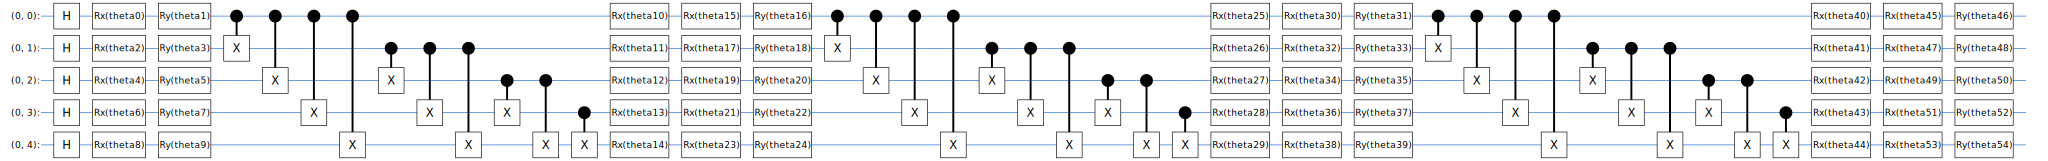

In [ ]:
# display the generator circuit
SVGCircuit(qgan.define_generator_circuit())

In [ ]:
# train the QGAN
print('Training started...')
print('Number of samples to process per epoch: ', num_elements)
print()
start_time_train = time.time()
model = qgan.train_qgan(gan_data, lucy_log_r_tf, transformed_lucy_OD, num_elements)
exec_time_train = time.time() - start_time_train
print(f'\nQGAN training completed. Training time: --- {exec_time_train/3600:.02f} hours ---')


Training started...
Number of samples to process per epoch:  384

Processing epoch 1/201


KeyboardInterrupt: 

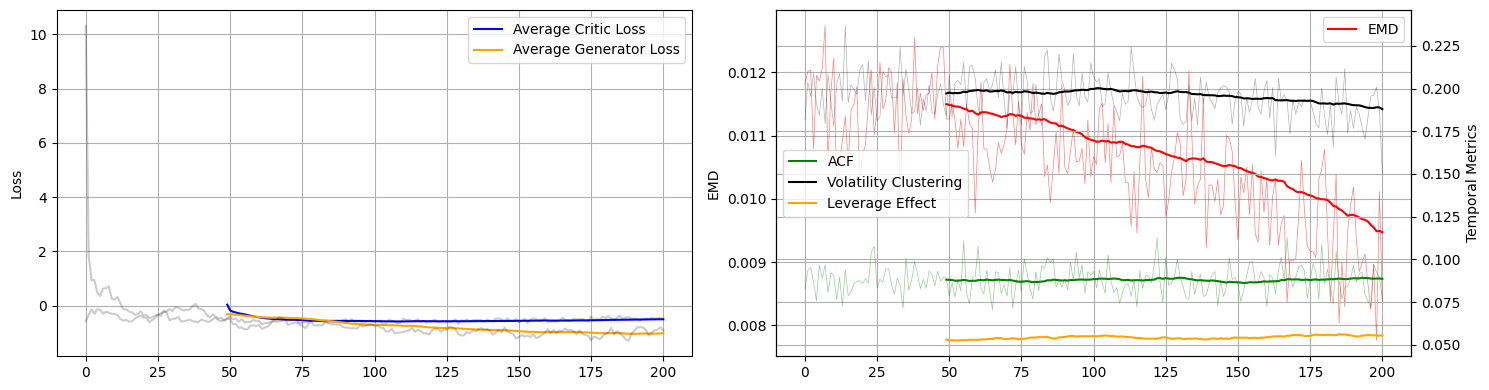

In [ ]:
critic_loss = tf.squeeze(qgan.critic_loss_avg, axis=(1,2)).numpy()
generator_loss = np.array(qgan.generator_loss_avg)

window = 50
generator_ma = np.convolve(generator_loss, np.ones(window)/window, mode='valid')
critic_ma = np.convolve(critic_loss, np.ones(window)/window, mode='valid')

# plot the graphs side-by-side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))

# plot the critic loss moving average as a line
axes[0].plot(range(window-1, len(critic_loss)), critic_ma, label='Average Critic Loss', color='blue')
# plot the critic loss
axes[0].plot(critic_loss, color='black', alpha=0.2)

# plot the generator loss moving average as a line
axes[0].plot(range(window-1, len(generator_loss)), generator_ma, label='Average Generator Loss', color='orange')
# plot the generator loss
axes[0].plot(generator_loss, color='black', alpha=0.2)


axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid()

emd_avg = np.array(qgan.emd_avg)
emd_ma = np.convolve(emd_avg, np.ones(window)/window, mode='valid')

axes[1].plot(range(window-1, len(emd_avg)), emd_ma, label='EMD', color='red')
axes[1].plot(emd_avg, color='red', linewidth=0.5, alpha=0.5)

axes[1].set_ylabel('EMD')
axes[1].legend()
axes[1].grid()

acf_avg = np.array(qgan.acf_avg)
vol_avg = np.array(qgan.vol_avg)
lev_avg = np.array(qgan.lev_avg)

acf_ma = np.convolve(acf_avg, np.ones(window)/window, mode='valid')
vol_ma = np.convolve(vol_avg, np.ones(window)/window, mode='valid')
lev_ma = np.convolve(lev_avg, np.ones(window)/window, mode='valid')

# Creating a twin axes for the second graph
axes2 = axes[1].twinx()

axes2.plot(range(window-1, len(acf_avg)), acf_ma, label='ACF', color='green')
axes2.plot(acf_avg, color='green', linewidth=0.5, alpha=0.4)

axes2.plot(range(window-1, len(vol_avg)), vol_ma, label='Volatility Clustering', color='black')
axes2.plot(vol_avg, color='black', linewidth=0.5, alpha=0.3)

axes2.plot(range(window-1, len(lev_avg)), lev_ma, label='Leverage Effect', color='orange')

axes2.set_ylabel('Temporal Metrics')
axes2.legend()
axes2.grid()

# Adjusting the spacing between subplots
plt.tight_layout()

In [ ]:

print(f"window: {window}, len(critic_loss): {len(critic_loss)}")

window: 50, len(critic_loss): 201


In [ ]:
# generate noise
num_samples = len(lucy_log_r_tf) // WINDOW_LENGTH
input_circuits_batch = []
for _ in range(num_samples):
    noise_values = np.random.uniform(0, 2 * np.pi, size=NUM_QUBITS)
    input_circuits_batch.append(qgan.encoding_layer(noise_values))

# convert to tensorflow quantum tensor
generator_inputs = tfq.convert_to_tensor(input_circuits_batch)
# generate fake samples using the generator
batch_generated = qgan.generator(generator_inputs)
# concatenate all time series data into one
generated_data = tf.reshape(batch_generated, shape=(num_samples*WINDOW_LENGTH,))
generated_data = tf.cast(generated_data, dtype=tf.float64)
# rescale
generated_data = rescale(generated_data, transformed_lucy_OD)
# reverse the preprocessing on generated sample
original_norm = lambert_w_transform(generated_data, 1)
fake_original = denormalize(original_norm, tf.reduce_mean(lucy_log_r_tf), tf.math.reduce_std(lucy_log_r_tf))

In [ ]:
print(len(date))
print(len(lucy_log_r_tf))

778
777


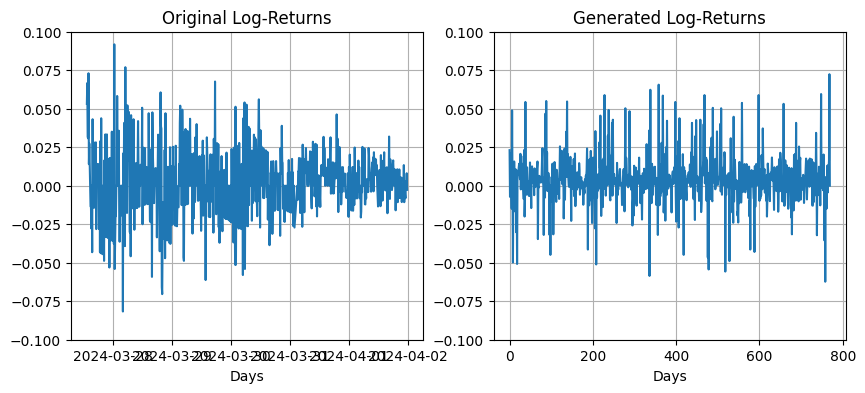

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
###################################################################################################################
#
# plot original log-returns on the left and the generated on the right
#
###################################################################################################################
axes[0].plot(date[1:], lucy_log_r_tf) #[1:][1:]
axes[0].set_xlabel('Days')
axes[0].set_title('Original Log-Returns')
axes[0].grid()
axes[0].set_ylim([-0.1, 0.1])


axes[1].plot(fake_original)
axes[1].set_xlabel('Days')
axes[1].set_title('Generated Log-Returns')
axes[1].grid()
axes[1].set_ylim([-0.1, 0.1])
plt.show()

In [ ]:
df = pd.DataFrame(fake_original)

# Save the DataFrame to a CSV file
csv_filename = 'fake_orignial_lucy_log_returns.csv'
df.to_csv(csv_filename, index=False)

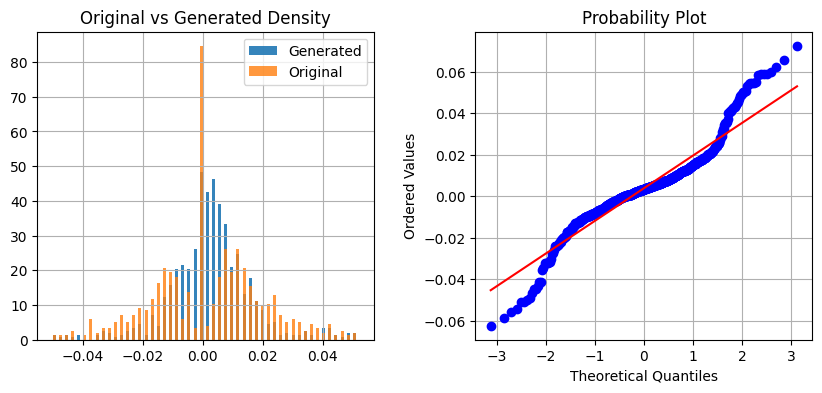

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
###################################################################################################################
#
# plot histogram of generated along with original log-returns on the left and the Q-Q plot on the right
#
###################################################################################################################
bin_edges = np.linspace(-0.05, 0.05, num=50)  # define the bin edges
bin_width = bin_edges[1] - bin_edges[0]
bin_edges = np.append(bin_edges, bin_edges[-1] + bin_width)
axes[0].hist(fake_original, bins=bin_edges, density=True, width=0.001, label='Generated', alpha=0.9)
axes[0].hist(lucy_log_r_tf, bins=bin_edges, density=True, width=0.001, label='Original', alpha=0.8)
axes[0].set_title('Original vs Generated Density')
axes[0].grid()
axes[0].legend()

probplot(fake_original, dist='norm', plot=axes[1])
axes[1].set_xlabel('Theoretical Quantiles')
axes[1].grid()

plt.subplots_adjust(wspace=0.3)

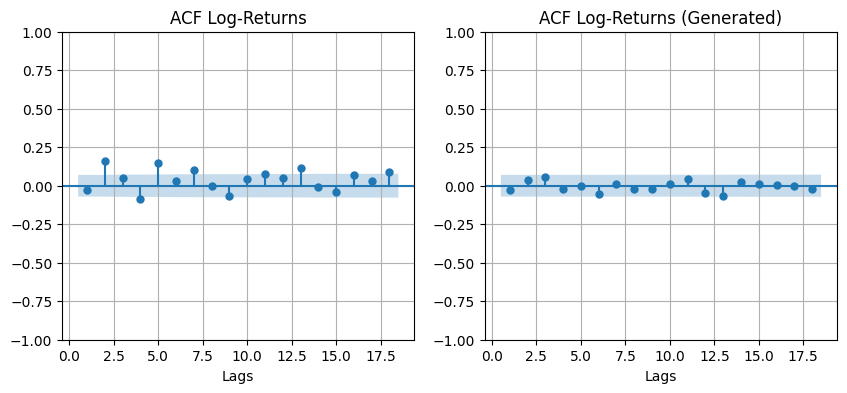

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
###################################################################################################################
#
# plot autocorrelations of original log-returns on the left and the generated on the right
#
###################################################################################################################
tsaplots.plot_acf(lucy_log_r_tf, ax=axes[0], lags=18, zero=False)
axes[0].set_xlabel('Lags')
axes[0].set_title('ACF Log-Returns')
axes[0].grid()

tsaplots.plot_acf(fake_original, ax=axes[1], lags=18, zero=False)
axes[1].set_xlabel('Lags')
axes[1].set_title('ACF Log-Returns (Generated)')
axes[1].grid()

plt.show()

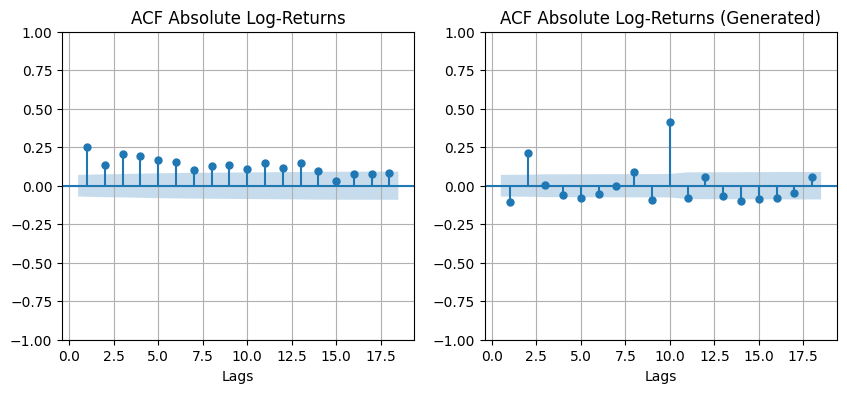

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
###################################################################################################################
#
# plot volatility clustering of original log-returns on the left and the generated on the right
#
###################################################################################################################
tsaplots.plot_acf(tf.abs(lucy_log_r_tf), ax=axes[0], lags=18, zero=False)
axes[0].set_xlabel('Lags')
axes[0].set_title('ACF Absolute Log-Returns')
axes[0].grid()

tsaplots.plot_acf(tf.abs(fake_original), ax=axes[1], lags=18, zero=False)
axes[1].set_xlabel('Lags')
axes[1].set_title('ACF Absolute Log-Returns (Generated)')
axes[1].grid()

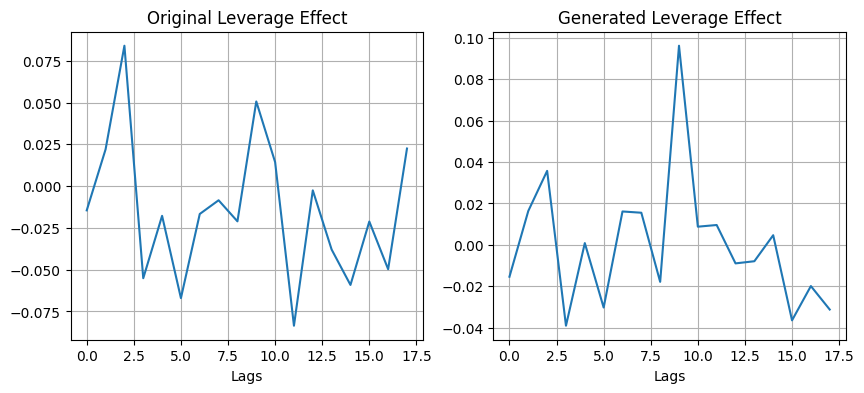

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
###################################################################################################################
#
# plot leverage effect of original log-returns on the left and the generated on the right
#
###################################################################################################################
# compute leverage effect for maximum lags = 18
leverage_original = []
for lag in range(1, 19):
    # slice the tensors to get the appropriate lagged sequences
    r_t = lucy_log_r_tf[:-lag]
    squared_lag_r = tf.square(tf.abs(lucy_log_r_tf[lag:]))

    # calculate the leverage effect
    # calculate the correlation coefficient
    correlation_matrix = np.corrcoef(r_t, squared_lag_r)
    leverage_original.append(correlation_matrix[0, 1])

leverage_generated = []
for lag in range(1, 19):
    # slice the tensors to get the appropriate lagged sequences
    r_t = fake_original[:-lag]
    squared_lag_r = tf.square(tf.abs(fake_original[lag:]))

    # calculate the leverage effect
    # calculate the correlation coefficient
    correlation_matrix = np.corrcoef(r_t, squared_lag_r)
    leverage_generated.append(correlation_matrix[0, 1])

axes[0].plot(leverage_original)
axes[0].set_xlabel('Lags')
axes[0].set_title('Original Leverage Effect')
axes[0].grid()

axes[1].plot(leverage_generated)
axes[1].set_xlabel('Lags')
axes[1].set_title('Generated Leverage Effect')
axes[1].grid()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from scipy.stats import wasserstein_distance, norm
from scipy.stats import entropy
from statsmodels.graphics import tsaplots

In [ ]:
# First, let's reload the original datasets since the previous dataframes have been altered through oversampling
real_data = pd.read_csv('original_lucy_log_returns.csv')
#fake_data = pd.read_csv('/content/fake_original(BATCH_50) (2).csv')
#fake_data = pd.read_csv('/content/(forse)fake_original_BATCH_50_LAMBDA_8.csv')
#fake_data = pd.read_csv('/content/fake_original_2000_epochs.csv')
#fake_data = pd.read_csv('/content/fake_original_1701_epochs .csv')
fake_data = pd.read_csv ('/content/fake_orignial_lucy_log_returns.csv')
#fake_data = pd.read_csv ('/content/fake_original_2000_stride_2_batch_40.csv')
lucy = pd.read_csv('lucy2.csv')
# Rename the columns for clarity
real_data.rename(columns={'0': 'Log_Return'}, inplace=True)
fake_data.rename(columns={'0': 'Log_Return'}, inplace=True)
#forse_data.rename(columns={'0': 'Log_Return'}, inplace=True)

real_data.drop(real_data.tail(1).index, inplace=True)

In [ ]:
date = lucy['DATE'][1:-1]
date = date.reset_index(drop=True)
real_data['DATE'] = date
#orig_data= orig_data.set_index('Date')
# Convert 'DATE' column to datetime with the correct format
real_data['DATE']= pd.to_datetime(real_data['DATE'], format= 'mixed')
for i in range(len(real_data['DATE'])):
    if real_data['DATE'][i].month ==1:
        real_data.loc[i,'DATE']= real_data['DATE'][i].replace(month=4)
        real_data.loc[i,'DATE']= real_data['DATE'][i].replace(day=1)
real_data.head()

print(real_data)
real_data

     Log_Return                DATE
0      0.053110 2024-03-27 13:22:00
1      0.066691 2024-03-27 13:32:00
2      0.031749 2024-03-27 13:42:00
3      0.030772 2024-03-27 13:52:00
4      0.073025 2024-03-27 14:02:00
..          ...                 ...
771   -0.005376 2024-04-01 22:52:00
772   -0.008119 2024-04-01 23:02:00
773    0.002714 2024-04-01 23:12:00
774    0.000000 2024-04-01 23:22:00
775    0.008097 2024-04-01 23:32:00

[776 rows x 2 columns]


,Log_Return,DATE
0,0.053110,2024-03-27 13:22:00
1,0.066691,2024-03-27 13:32:00
2,0.031749,2024-03-27 13:42:00
3,0.030772,2024-03-27 13:52:00
4,0.073025,2024-03-27 14:02:00
...,...,...
771,-0.005376,2024-04-01 22:52:00
772,-0.008119,2024-04-01 23:02:00
773,0.002714,2024-04-01 23:12:00
774,0.000000,2024-04-01 23:22:00


In [ ]:
fake_data['DATE'] = date
#false_data= false_data.set_index('Date')
# Convert 'DATE' column to datetime with the correct format
fake_data['DATE']= pd.to_datetime(fake_data['DATE'], format= 'mixed')
for i in range(len(fake_data['DATE'])):
    if real_data['DATE'][i].month ==1:
        fake_data.loc[i,'DATE']= fake_data['DATE'][i].replace(month=4)
        fake_data.loc[i,'DATE']= fake_data['DATE'][i].replace(day=1)
fake_data.head()

print(fake_data)
fake_data

     Log_Return                DATE
0      0.023084 2024-03-27 13:22:00
1     -0.007202 2024-03-27 13:32:00
2     -0.002494 2024-03-27 13:42:00
3      0.021282 2024-03-27 13:52:00
4      0.000181 2024-03-27 14:02:00
..          ...                 ...
765    0.013134 2024-01-04 21:52:00
766    0.010652 2024-01-04 22:02:00
767    0.016565 2024-01-04 22:12:00
768    0.072406 2024-01-04 22:22:00
769   -0.000006 2024-01-04 22:32:00

[770 rows x 2 columns]


,Log_Return,DATE
0,0.023084,2024-03-27 13:22:00
1,-0.007202,2024-03-27 13:32:00
2,-0.002494,2024-03-27 13:42:00
3,0.021282,2024-03-27 13:52:00
4,0.000181,2024-03-27 14:02:00
...,...,...
765,0.013134,2024-01-04 21:52:00
766,0.010652,2024-01-04 22:02:00
767,0.016565,2024-01-04 22:12:00
768,0.072406,2024-01-04 22:22:00


In [ ]:
# Save the DataFrame to a CSV file
csv_filename = 'fake.csv'
fake_data.to_csv(csv_filename, index=False)

In [ ]:
# Save the DataFrame to a CSV file
csv_filename = 'real.csv'
real_data.to_csv(csv_filename, index=False)

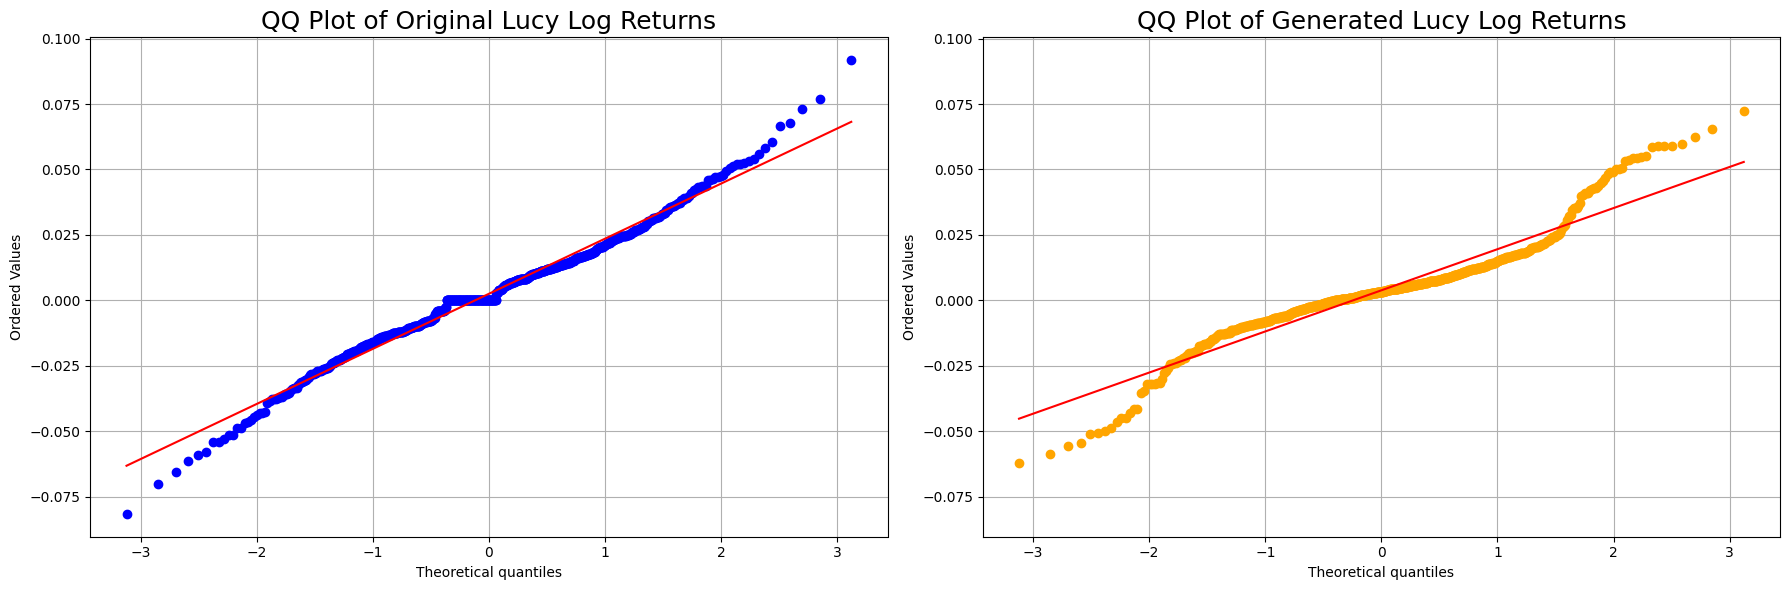

In [ ]:
# Ensure both time series are of the same length for comparison
min_length = min(len(real_data), len(fake_data))
real_ts = real_data['Log_Return'][:min_length]
fake_ts = fake_data['Log_Return'][:min_length]

# Generate QQ plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# QQ plot for the original Lucy log returns
stats.probplot(real_ts, dist="norm", plot=ax1)
ax1.set_title('QQ Plot of Original Lucy Log Returns', fontsize= 18)
ax1.grid(True)

# QQ plot for the generated Lucy log returns
stats.probplot(fake_ts, dist="norm", plot=ax2)
ax2.get_lines()[0].set_color('orange')
ax2.set_title('QQ Plot of Generated Lucy Log Returns', fontsize= 18)
ax2.grid(True)

# Set the same scale for y axis
axes = plt.gca()
ylim1 = ax1.get_ylim()
ylim2 = ax2.get_ylim()
global_ylim = (min(ylim1[0], ylim2[0]), max(ylim1[1], ylim2[1]))
ax1.set_ylim(global_ylim)
ax2.set_ylim(global_ylim)

# Show the plots
plt.tight_layout()
plt.show()

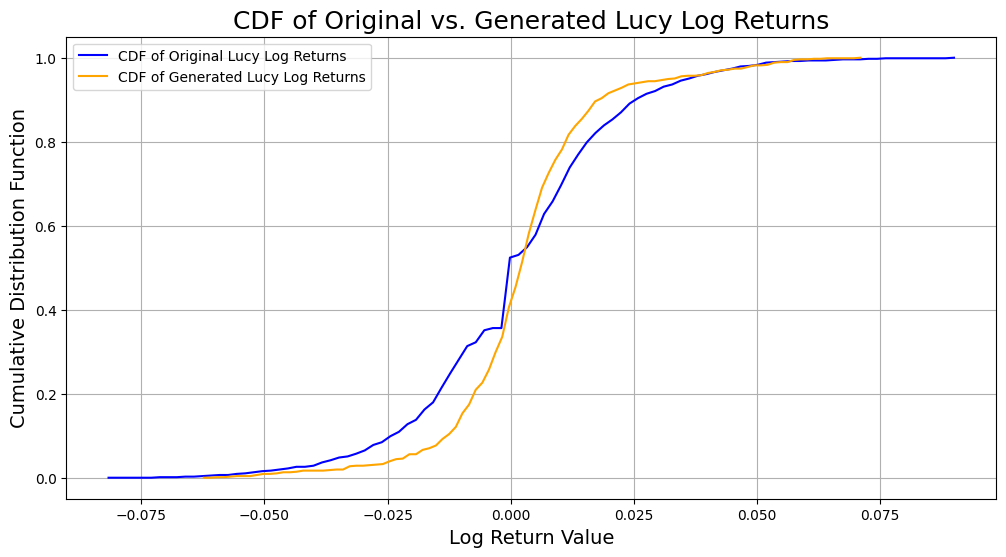

In [ ]:
# Calculate the probability distribution of the real and fake time series
real_ts_values, real_ts_base = np.histogram(real_ts, bins=100, density=True)
fake_ts_values, fake_ts_base = np.histogram(fake_ts, bins=100, density=True)

# Compute the cumulative distribution functions for both time series
real_ts_cdf = np.cumsum(real_ts_values * np.diff(real_ts_base))
fake_ts_cdf = np.cumsum(fake_ts_values * np.diff(fake_ts_base))

# Plotting the probability distributions of the real and fake time series
plt.figure(figsize=(12, 6))
plt.plot(real_ts_base[:-1], real_ts_cdf, label='CDF of Original Lucy Log Returns', color='blue')
plt.plot(fake_ts_base[:-1], fake_ts_cdf, label='CDF of Generated Lucy Log Returns', color='orange')
plt.xlabel('Log Return Value',fontsize=14)
plt.ylabel('Cumulative Distribution Function',fontsize=14)
plt.title('CDF of Original vs. Generated Lucy Log Returns',fontsize=18)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

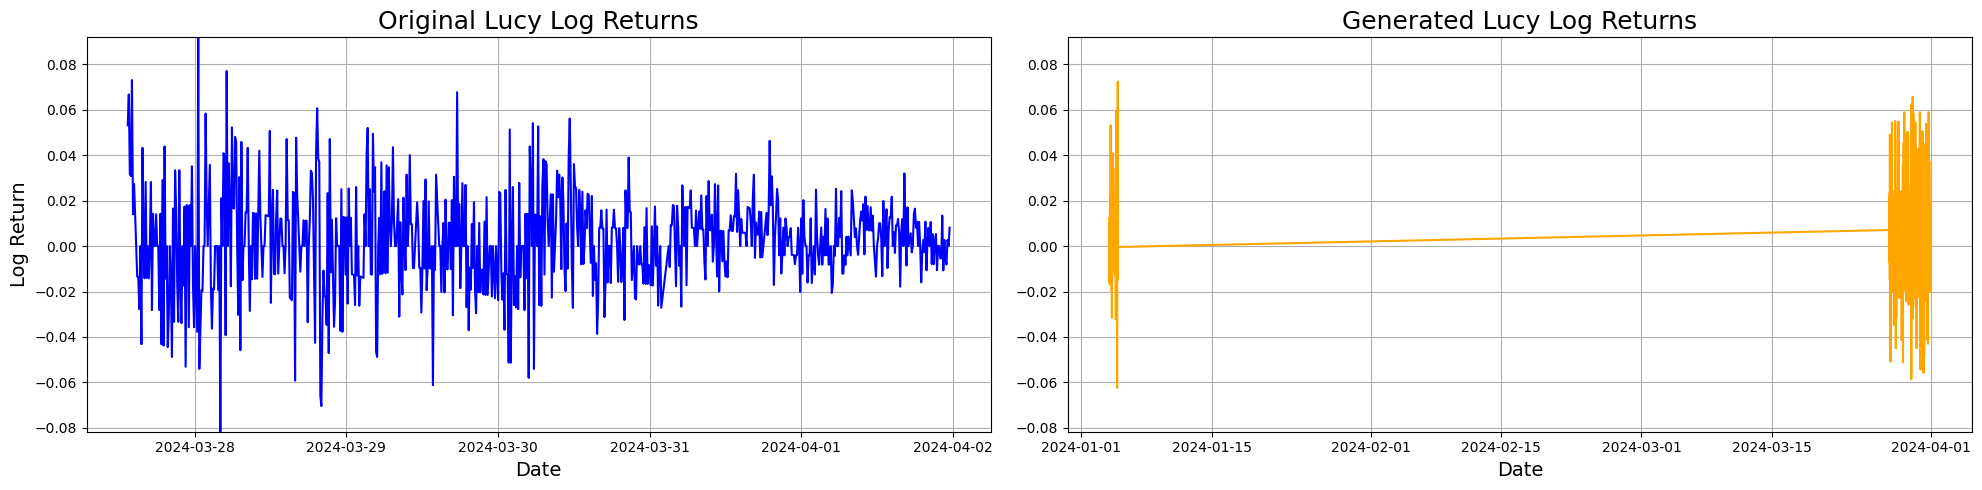

In [ ]:
# Plotting the time series with the same y-axis scale

# Convert 'Date' columns to datetime for proper plotting
real_data['DATE'] = pd.to_datetime(real_data['DATE'])
fake_data['DATE'] = pd.to_datetime(fake_data['DATE'])

# Determine the global min and max log return values for the y-axis scale
min_log_return = min(real_data['Log_Return'].min(), fake_data['Log_Return'].min())
max_log_return = max(real_data['Log_Return'].max(), fake_data['Log_Return'].max())

# Plot both time series with the same y-axis scale
plt.figure(figsize=(20, 5))

# Plotting the original S&P 500 Log Returns
plt.subplot(1, 2, 1)
plt.plot(real_data['DATE'], real_data['Log_Return'], color='blue')
plt.title('Original Lucy Log Returns',fontsize=18)
plt.xlabel('Date',fontsize=14)
plt.ylabel('Log Return',fontsize=14)
plt.ylim(min_log_return, max_log_return)
plt.grid(True)

# Plotting the generated S&P 500 Log Returns
plt.subplot(1, 2, 2)
plt.plot(fake_data['DATE'], fake_data['Log_Return'], color='orange')
plt.title('Generated Lucy Log Returns',fontsize=18)
plt.xlabel('Date',fontsize=14)
plt.ylim(min_log_return, max_log_return)
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()



<ipython-input-68-2915247ae7ca>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(real_ts, hist=False, kde=True,
<ipython-input-68-2915247ae7ca>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(fake_ts, hist=False, kde=True,


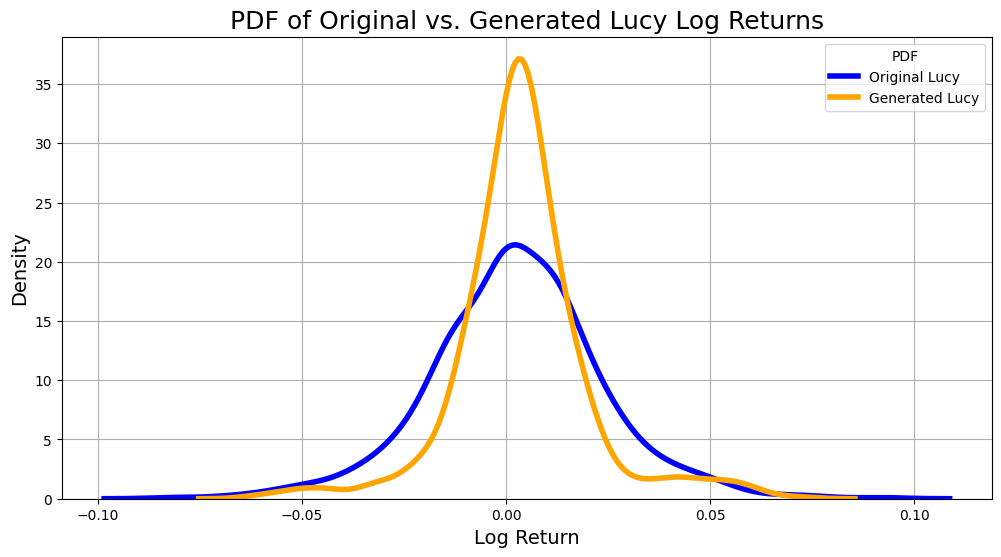

In [ ]:
# We will use seaborn's distplot to plot the PDFs of the real and fake data
plt.figure(figsize=(12, 6))

# Plotting the PDF of the original S&P 500 Log Returns
sns.distplot(real_ts, hist=False, kde=True,
             bins=100, color = 'blue',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
             label='Original Lucy')

# Plotting the PDF of the generated S&P 500 Log Returns
sns.distplot(fake_ts, hist=False, kde=True,
             bins=100, color = 'orange',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
             label='Generated Lucy')

# Plot formatting
plt.legend(prop={'size': 10}, title = 'PDF')
plt.title('PDF of Original vs. Generated Lucy Log Returns', fontsize = 18)
plt.xlabel('Log Return', fontsize = 14)
plt.ylabel('Density', fontsize = 14)
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
# Calculate the Earth Mover's distance (also known as Wasserstein distance) between the two distributions
emd_value = wasserstein_distance(real_ts, fake_ts)
emd_value


0.005241845811679186

In [ ]:
# Calculate the entropy of the two distributions
# First, we need to calculate the probability distributions (histograms) with the same bins for both time series
real_ts_prob, bins = np.histogram(real_ts, bins=100, density=True)
fake_ts_prob, _ = np.histogram(fake_ts, bins=bins, density=True)

# The histograms are used to approximate the probability distributions, we can now calculate the entropy
# Entropy of the real time series
entropy_real = entropy(real_ts_prob)
# Entropy of the generated time series
entropy_fake = entropy(fake_ts_prob)

entropy_real, entropy_fake

(3.6324927513522516, 3.4236081988107125)

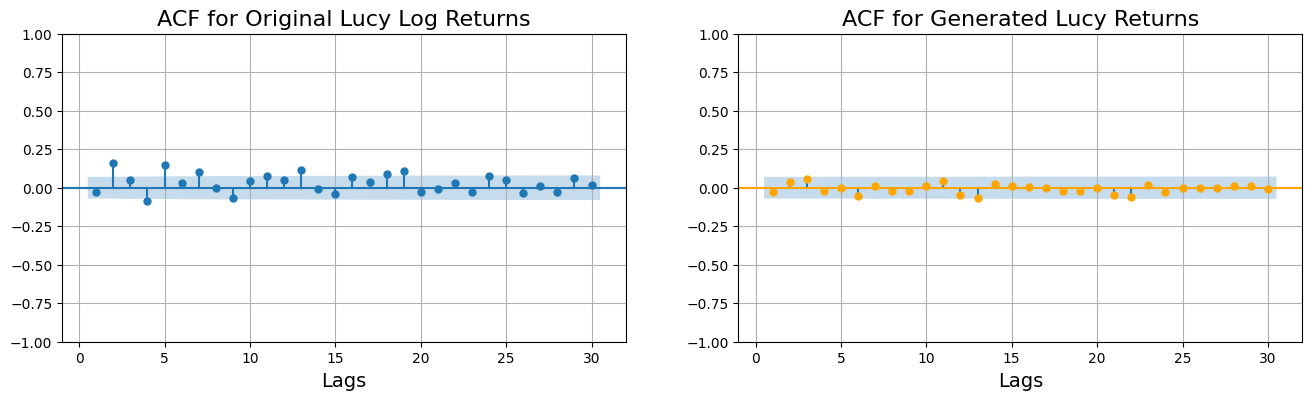

In [ ]:
from statsmodels.graphics import tsaplots

# Creating the ACF plots using the provided code structure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

# Plot autocorrelations of original log-returns on the left
tsaplots.plot_acf(real_ts, ax=axes[0], lags=30, zero=False)
axes[0].set_xlabel('Lags', fontsize = 14)
axes[0].set_title('ACF for Original Lucy Log Returns', fontsize = 16)
axes[0].grid()

# Plot autocorrelations of generated log-returns on the right
tsaplots.plot_acf(fake_ts, ax=axes[1], lags=30, zero=False, color='orange')
axes[1].set_xlabel('Lags', fontsize = 14)
axes[1].set_title('ACF for Generated Lucy Returns', fontsize = 16)
axes[1].grid()

plt.show()


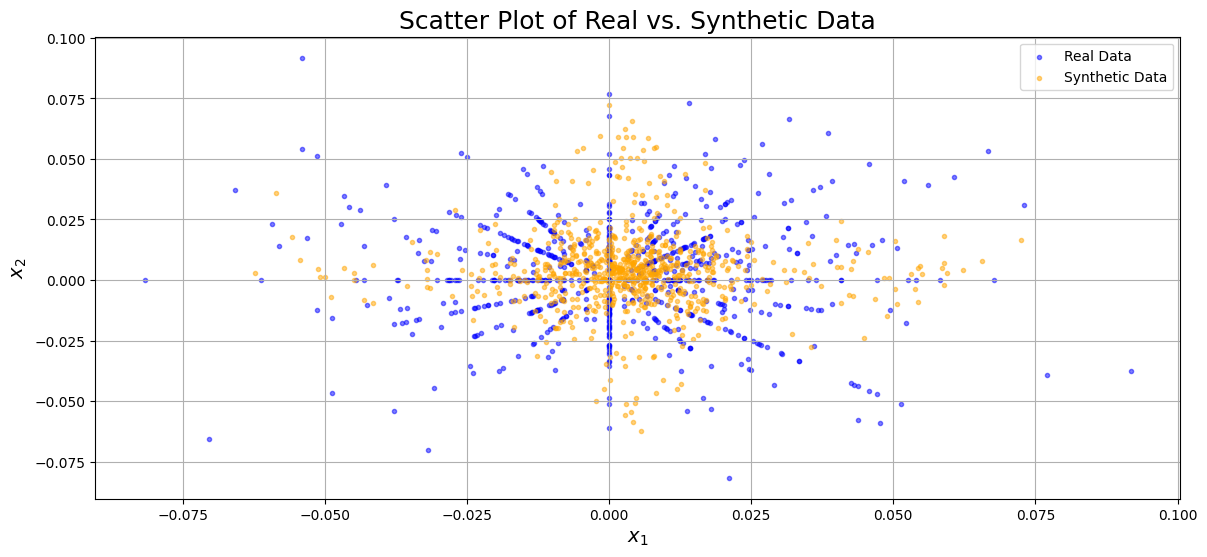

In [ ]:
# To reproduce a similar scatter plot for the time series, we will plot the real data against the generated data.
# Since we only have one dimension (the log returns), we'll create a lagged version of the data to allow for a 2D scatter plot.

# Create a lagged version of the time series
real_ts_lagged = real_ts.shift(1).dropna()
fake_ts_lagged = fake_ts.shift(1).dropna()

# Take the same number of points from each to have a fair comparison
min_length = min(len(real_ts_lagged), len(fake_ts_lagged))
real_ts_plot = real_ts_lagged.iloc[:min_length]
fake_ts_plot = fake_ts_lagged.iloc[:min_length]
real_ts_current = real_ts.iloc[1:min_length+1]
fake_ts_current = fake_ts.iloc[1:min_length+1]

# Plot
plt.figure(figsize=(14, 6))
plt.scatter(real_ts_current, real_ts_plot, color='blue', alpha=0.5, label='Real Data', marker='.')
plt.scatter(fake_ts_current, fake_ts_plot, color='orange', alpha=0.5, label='Synthetic Data', marker='.')
plt.xlabel('$x_1$', fontsize = 14)
plt.ylabel('$x_2$', fontsize = 14)
plt.title('Scatter Plot of Real vs. Synthetic Data', fontsize = 18)
plt.legend()
plt.grid()
plt.show()

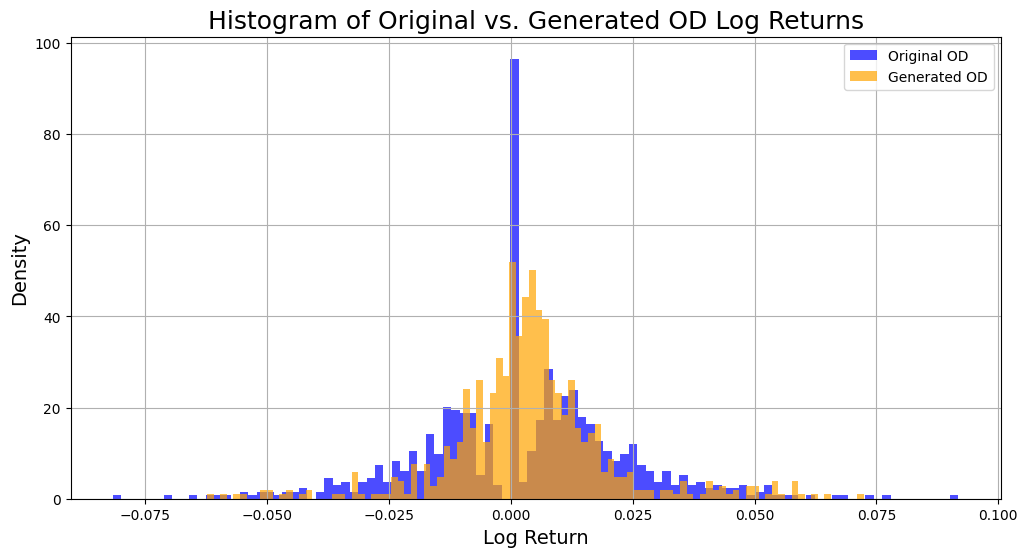

In [ ]:
# Plotting the histograms of the two time series one over the other

plt.figure(figsize=(12, 6))

# Plotting the histogram for the original S&P 500 Log Returns
plt.hist(real_ts, bins=100, alpha=0.7, label='Original OD', color='blue', density = True)

# Plotting the histogram for the generated S&P 500 Log Returns
plt.hist(fake_ts, bins=100, alpha=0.7, label='Generated OD', color='orange', density = True)

plt.xlabel('Log Return', fontsize = 14)
plt.ylabel('Density', fontsize = 14)
plt.title('Histogram of Original vs. Generated OD Log Returns', fontsize = 18)
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

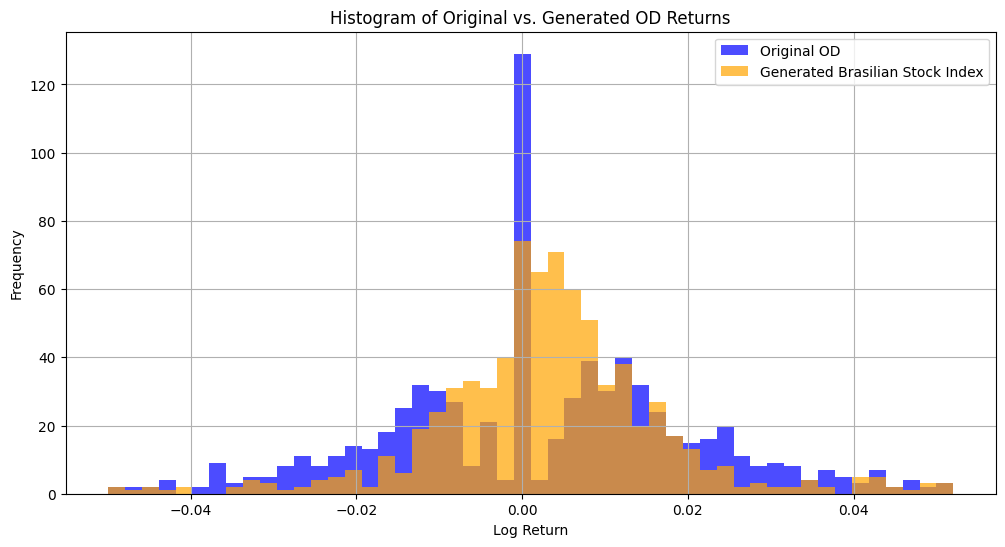

In [ ]:
# Plotting the histograms of the two time series one over the other

plt.figure(figsize=(12, 6))
bin_edges = np.linspace(-0.05, 0.05, num=50)  # define the bin edges
bin_width = bin_edges[1] - bin_edges[0]
bin_edges = np.append(bin_edges, bin_edges[-1] + bin_width)
# Plotting the histogram for the original S&P 500 Log Returns
plt.hist(real_ts, bins=bin_edges, alpha=0.7, label='Original OD', color='blue')

# Plotting the histogram for the generated S&P 500 Log Returns
plt.hist(fake_ts, bins=bin_edges, alpha=0.7, label='Generated Brasilian Stock Index', color='orange')

plt.xlabel('Log Return')
plt.ylabel('Frequency')
plt.title('Histogram of Original vs. Generated OD Returns')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

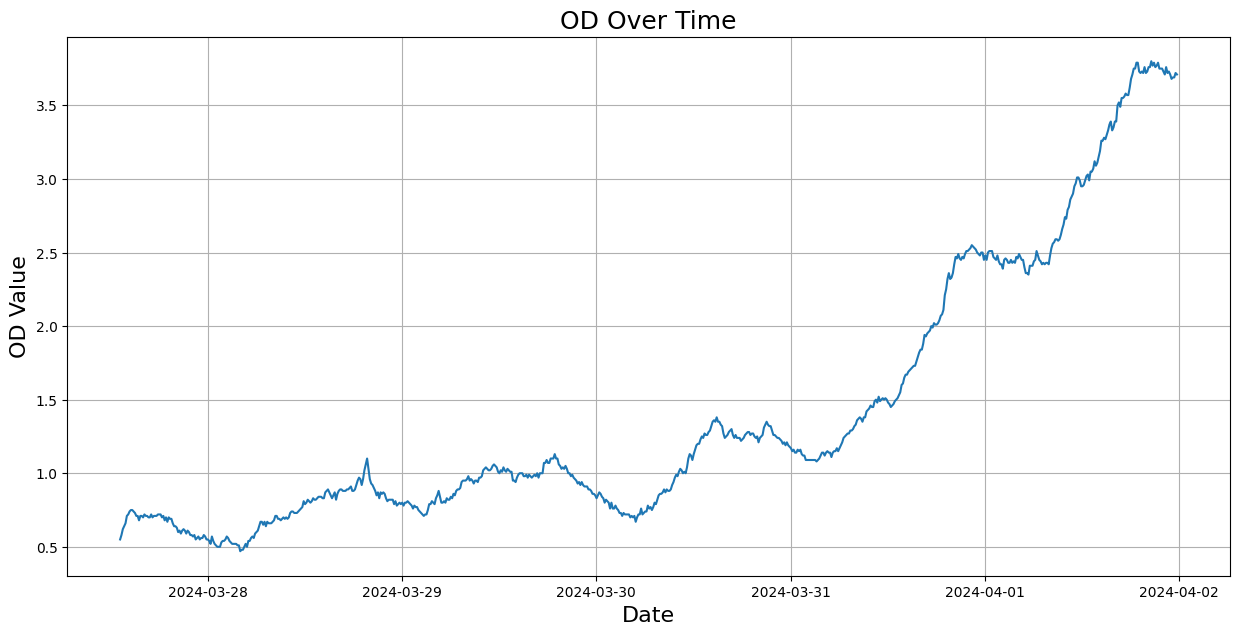

In [ ]:
# Converting the 'Date' column to datetime
lucy['DATE'] = pd.to_datetime(lucy['DATE'], format= 'mixed')
for i in range(len(lucy['DATE'])):
    if lucy['DATE'][i].month ==1:
        lucy.loc[i,'DATE']= lucy['DATE'][i].replace(month=4)
        lucy.loc[i,'DATE']= lucy['DATE'][i].replace(day=1)
lucy.head()
# Plotting the closing price
plt.figure(figsize=(15, 7))
plt.plot(lucy['DATE'], lucy['OD'], label='OD Value')
plt.title('OD Over Time', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('OD Value', fontsize=16)
plt.grid(True)

plt.show()

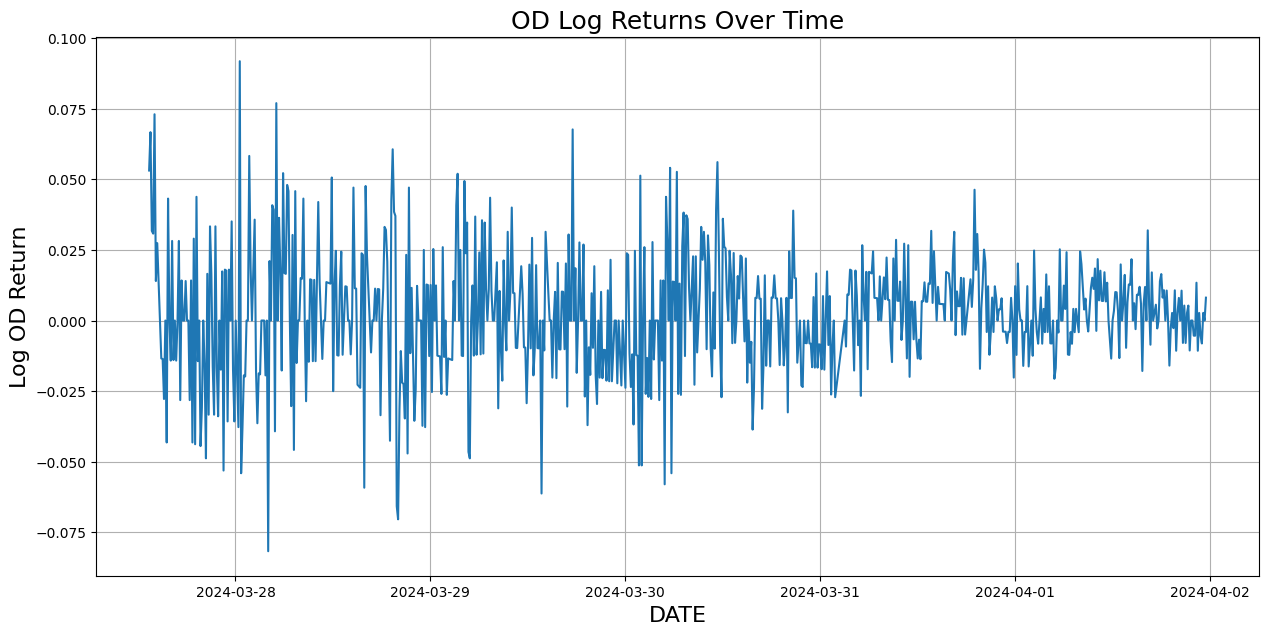

In [ ]:
# Converting the 'Date' column to datetime
real_data['DATE'] = pd.to_datetime(real_data['DATE'])

# Plotting the closing price
plt.figure(figsize=(15, 7))
plt.plot(real_data['DATE'], real_data['Log_Return'], label='Log OD Value')
plt.title('OD Log Returns Over Time', fontsize=18)
plt.xlabel('DATE', fontsize=16)
plt.ylabel('Log OD Return', fontsize=16)
plt.grid(True)

plt.show()

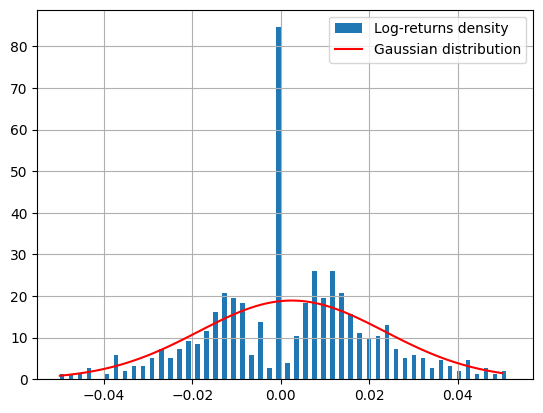

In [ ]:
# density of log-returns
bin_edges = np.linspace(-0.05, 0.05, num=50)  # define the bin edges
bin_width = bin_edges[1] - bin_edges[0]
bin_edges = np.append(bin_edges, bin_edges[-1] + bin_width)
plt.hist(real_data['Log_Return'], bins=bin_edges, density=True, width=0.001, label='Log-returns density')
plt.grid()

# normal distribution with same mean and standard deviation as log-returns
mu = np.mean(real_data['Log_Return'])
sigma = np.std(real_data['Log_Return'])

# Generate a set of points x
x = np.linspace(-0.05, 0.05, 100)

# Generate the Gaussian PDF for the points x with same mean and standard deviation as the log-returns
pdf = norm.pdf(x, mu, sigma)

# plot the Gaussian PDF
plt.plot(x, pdf, 'r', label='Gaussian distribution')
plt.legend()

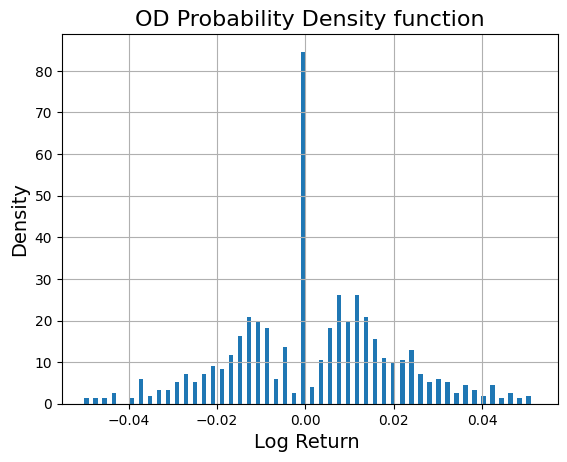

In [ ]:
# density of log-returns
bin_edges = np.linspace(-0.05, 0.05, num=50)  # define the bin edges
bin_width = bin_edges[1] - bin_edges[0]
bin_edges = np.append(bin_edges, bin_edges[-1] + bin_width)
plt.hist(real_data['Log_Return'], bins=bin_edges, density=True, width=0.001, label='Log-returns density')
plt.title('OD Probability Density function',fontsize=16 )
plt.xlabel('Log Return ',fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.grid()

In [ ]:
min (fake_ts), max(fake_ts)

(-0.0623356902214604, 0.0724062802840155)

In [ ]:
min (real_ts), max(real_ts)

(-0.0816780310142671, 0.0918075492531226)

In [ ]:
pip install fastdtw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512548 sha256=5e9f43827dba2b0b31239b49b60a62039c6ac8a8144265e4d340588a12476a8b
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d513c736bb93910277e1528ef4
Successfully built fastdtw


In [ ]:
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

In [ ]:
series1 = real_data['Log_Return'].to_numpy().reshape(-1,1)
series2 = fake_data['Log_Return'].to_numpy().reshape(-1,1)

In [ ]:
dtw_distance, warping_path = fastdtw(series1,series2, dist=euclidean)

In [ ]:
dtw_distance

11.638172236542907

In [ ]:
pip install dtaidistance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 20.7 MB/s eta 0:00:00


(<Figure size 1000x1000 with 4 Axes>, [<Axes: >, <Axes: >, <Axes: >, <Axes: >])

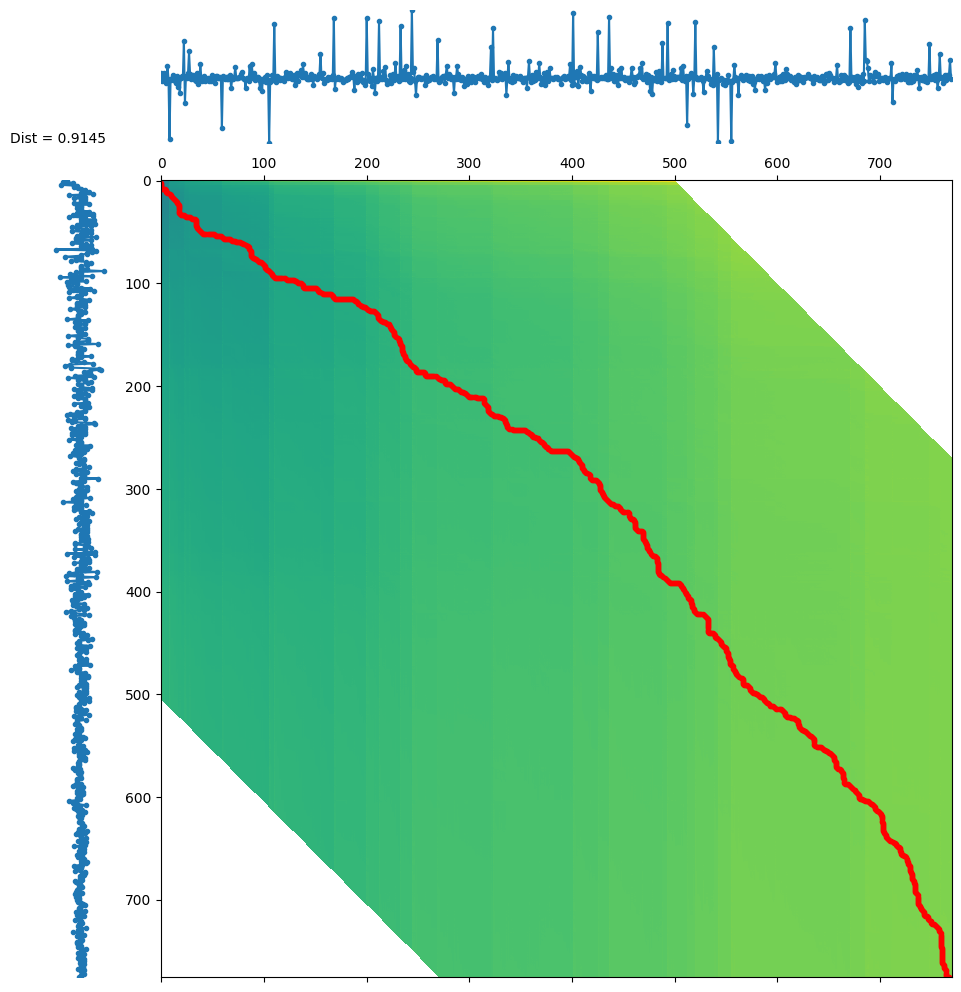

In [ ]:
from dtaidistance import dtw_visualisation as dtwvis
import random
from dtaidistance import dtw
import numpy as np

for idx in range(len(series2)):
    if random.random() < 0.05:
        series2[idx] += (random.random() - 0.5) / 2
d, paths = dtw.warping_paths(series1, series2, window=500, psi=2)
best_path = dtw.best_path(paths)
dtwvis.plot_warpingpaths(series1, series2, paths, best_path)

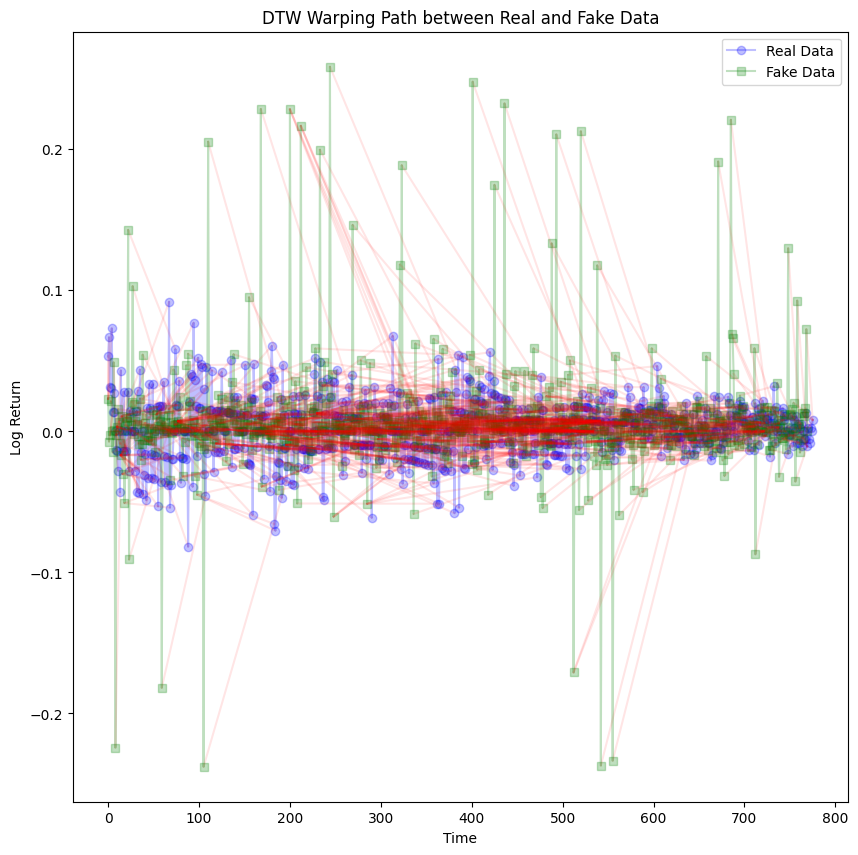

In [ ]:
# Re-attempt to plot the warping path correctly

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the first series on the x-axis
ax.plot(series1, 'bo-', label='Real Data', alpha = 0.25)


# Plot the second series on the y-axis
ax.plot(series2, 'gs-', label='Fake Data', alpha = 0.25)

# Draw lines between the matched points in the warping path
for (i, j) in warping_path:
    ax.plot([i, j], [series1[i], series2[j]], 'r-', alpha=0.1)

# Labeling the plot
ax.set_xlabel('Time')
ax.set_ylabel('Log Return')
ax.set_title('DTW Warping Path between Real and Fake Data')
ax.legend()
plt.show()

In [ ]:
d

0.9145060408603357

# only Original

In [ ]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit



import warnings
warnings.filterwarnings('ignore')

In [ ]:
# First, let's reload the original datasets since the previous dataframes have been altered through oversampling
orig_data = pd.read_csv('/content/original_lucy_log_returns.csv')

# Rename the columns for clarity
orig_data.rename(columns={'0': 'Log_Return'}, inplace=True)
orig_data.drop(orig_data.tail(1).index, inplace=True)


In [ ]:
orig_data


,Log_Return
0,0.053110
1,0.066691
2,0.031749
3,0.030772
4,0.073025
...,...
771,-0.005376
772,-0.008119
773,0.002714
774,0.000000


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Function to prepare data for LSTM model
def prepare_lstm_data(df, n_steps):
    X, y = [], []
    for i in range(len(df) - n_steps):
        X.append(df[i:i + n_steps])
        y.append(df[i + n_steps])
    return np.array(X), np.array(y)

# Number of past days to use for predicting the next value
n_steps = 10

# Selecting the 'Log_Return' column from prova_df for LSTM input
prova_log_returns = orig_data['Log_Return'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
prova_scaled = scaler.fit_transform(prova_log_returns)

# Prepare data for LSTM
X_prova, y_prova = prepare_lstm_data(prova_scaled, n_steps)

# Split the data into training and testing sets
X_train_prova, X_test_prova, y_train_prova, y_test_prova = train_test_split(X_prova, y_prova, test_size=0.01, random_state=42)

X_train_prova.shape, X_test_prova.shape, y_train_prova.shape, y_test_prova.shape


((758, 10, 1), (8, 10, 1), (758, 1), (8, 1))

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [ ]:
X_train_prova.shape

(758, 10, 1)

In [ ]:
input_shape = (10,1)
#input_shape= (X_train_prova[1],X_train_prova[2])
model = create_lstm_model(input_shape)
history = model.fit(X_train_prova, y_train_prova, epochs=100, batch_size=32, validation_data=(X_test_prova, y_test_prova))


Epoch 1/100
24/24 [==============================] - 11s 97ms/step - loss: 0.0594 - val_loss: 0.0103
Epoch 2/100
24/24 [==============================] - 1s 30ms/step - loss: 0.0175 - val_loss: 0.0057
Epoch 3/100
24/24 [==============================] - 1s 29ms/step - loss: 0.0166 - val_loss: 0.0036
Epoch 4/100
24/24 [==============================] - 1s 31ms/step - loss: 0.0161 - val_loss: 0.0036
Epoch 5/100
24/24 [==============================] - 1s 31ms/step - loss: 0.0161 - val_loss: 0.0036
Epoch 6/100
24/24 [==============================] - 1s 30ms/step - loss: 0.0158 - val_loss: 0.0039
Epoch 7/100
24/24 [==============================] - 1s 31ms/step - loss: 0.0163 - val_loss: 0.0038
Epoch 8/100
24/24 [==============================] - 1s 40ms/step - loss: 0.0154 - val_loss: 0.0039
Epoch 9/100
24/24 [==============================] - 1s 44ms/step - loss: 0.0158 - val_loss: 0.0041
Epoch 10/100
24/24 [==============================] - 1s 35ms/step - loss: 0.0157 - val_loss: 0.005

In [ ]:
predicted_prova = model.predict(X_test_prova)

1/1 [==============================] - 1s 1s/step


In [ ]:
from sklearn.metrics import mean_squared_error

# Inverse transform the predictions and actual values to their original scale
predicted_prova_inversed = scaler.inverse_transform(predicted_prova)
y_test_prova_inversed = scaler.inverse_transform(y_test_prova)

# Calculate MSE
mse_prova = mean_squared_error(y_test_prova_inversed, predicted_prova_inversed)
print("Mean Squared Error for Prova dataset:", mse_prova)


Mean Squared Error for Prova dataset: 0.00017403064588327242


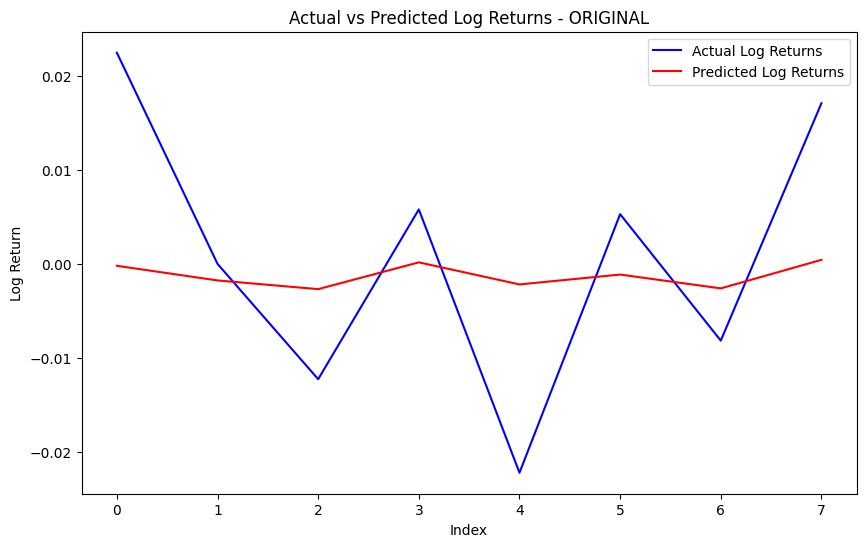

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test_prova_inversed, label='Actual Log Returns', color='blue')
plt.plot(predicted_prova_inversed, label='Predicted Log Returns', color='red')
plt.title('Actual vs Predicted Log Returns - ORIGINAL')
plt.xlabel('Index')
plt.ylabel('Log Return')
plt.legend()
plt.show()


In [ ]:
from math import sqrt
rmse = sqrt (mse_prova)
rmse

0.013192067536336843

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test_prova_inversed, predicted_prova_inversed)

0.011042535610239716

In [ ]:
# Generate predictions for the training set
predicted_train_prova = model.predict(X_train_prova)


24/24 [==============================] - 0s 9ms/step


In [ ]:
import matplotlib.pyplot as plt

# Inverse transform the predictions and actual values to their original scale
predicted_train_prova_inv = scaler.inverse_transform(predicted_train_prova)
y_train_prova_inv = scaler.inverse_transform(y_train_prova.reshape(-1, 1))


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate mean and standard deviation of the actual values
mu = np.mean(y_train_prova_inv)
sigma = np.std(y_train_prova_inv)

# Identify indices of extreme values
extreme_indices = np.where((y_train_prova_inv < (mu - 2 * sigma)) | (y_train_prova_inv > (mu + 2 * sigma)))[0]

# Filter actual and predicted values for extreme values
actual_extreme_values = y_train_prova_inv[extreme_indices]
predicted_extreme_values = predicted_train_prova_inv[extreme_indices]

# Calculate RMSE for extreme values
rmse_extreme = np.sqrt(mean_squared_error(actual_extreme_values, predicted_extreme_values))

print(f'RMSE for Extreme Values: {rmse_extreme}')


RMSE for Extreme Values: 0.054560704615028814


In [ ]:
mean_absolute_error(actual_extreme_values, predicted_extreme_values)

0.0534046091601195

In [ ]:
# Calculate mean and standard deviation of the actual values
mu = np.mean(y_test_prova_inversed)
sigma = np.std(y_test_prova_inversed)
# Identify indices of extreme values
extreme_indices = np.where((y_test_prova_inversed < (mu - 2 * sigma)) | (y_test_prova_inversed > (mu + 2 * sigma)))[0]

# Filter actual and predicted values for extreme values
actual_extreme_values = y_test_prova_inversed[extreme_indices]
predicted_extreme_values = predicted_prova_inversed[extreme_indices]

# Calculate RMSE for extreme values
rmse_extreme = np.sqrt(mean_squared_error(actual_extreme_values, predicted_extreme_values))

print(f'RMSE for Extreme Values: {rmse_extreme}')

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.

In [ ]:
mean_absolute_error(actual_extreme_values, predicted_extreme_values)

# Oversample

In [ ]:
import pandas as pd
from scipy.stats import zscore
import matplotlib.pyplot as plt


In [ ]:
# First, let's reload the original datasets since the previous dataframes have been altered through oversampling
orig_data = pd.read_csv('/content/original_lucy_log_returns.csv')
false_data = pd.read_csv('/content/fake_orignial_lucy_log_returns.csv')

# Rename the columns for clarity
orig_data.rename(columns={'0': 'Log_Return'}, inplace=True)
false_data.rename(columns={'0': 'Log_Return'}, inplace=True)
orig_data.drop(orig_data.tail(1).index, inplace=True)

In [ ]:
# Calculate mean and standard deviation of the original data
mean_orig = orig_data['Log_Return'].mean()
std_orig = orig_data['Log_Return'].std()

# Define the thresholds for extreme events
upper_threshold = mean_orig + 2 * std_orig
lower_threshold = mean_orig - 2 * std_orig

# Identify extreme events in both datasets
orig_data['Extreme_Event'] = ((orig_data['Log_Return'] > upper_threshold) |
                               (orig_data['Log_Return'] < lower_threshold))

false_data['Extreme_Event'] = ((false_data['Log_Return'] > upper_threshold) |
                               (false_data['Log_Return'] < lower_threshold))

# Add a column to track the data source
orig_data['Data_Source'] = 'Original'

# Replace non-extreme events in the original data with extreme events from the synthetic data
for i in range(min(len(orig_data), len(false_data))):
    if not orig_data.loc[i, 'Extreme_Event'] and false_data.loc[i, 'Extreme_Event']:
        orig_data.loc[i, 'Log_Return'] = false_data.loc[i, 'Log_Return']
        orig_data.loc[i, 'Data_Source'] = 'Synthetic'

orig_data.head()

,Log_Return,Extreme_Event,Data_Source
0,0.053110,True,Original
1,0.066691,True,Original
2,0.031749,False,Original
3,0.030772,False,Original
4,0.073025,True,Original


In [ ]:
orig_data['Extreme_Event_After'] = ((orig_data['Log_Return'] > upper_threshold) |
                                    (orig_data['Log_Return'] < lower_threshold))
extreme_count_after = orig_data['Extreme_Event_After'].sum()
extreme_count_after

78

In [ ]:
print(orig_data['Extreme_Event'].value_counts())
print(len(orig_data))
print(orig_data['Extreme_Event_After'].value_counts())


Extreme_Event
False    732
True      44
Name: count, dtype: int64
776
Extreme_Event_After
False    698
True      78
Name: count, dtype: int64


In [ ]:
orig_data

,Log_Return,Extreme_Event,Data_Source,Extreme_Event_After
0,0.053110,True,Original,True
1,0.066691,True,Original,True
2,0.031749,False,Original,False
3,0.030772,False,Original,False
4,0.073025,True,Original,True
...,...,...,...,...
771,-0.005376,False,Original,False
772,-0.008119,False,Original,False
773,0.002714,False,Original,False
774,0.000000,False,Original,False


In [ ]:
false_data

,Log_Return,Extreme_Event
0,0.023084,False
1,-0.007202,False
2,-0.002494,False
3,0.021282,False
4,0.000181,False
...,...,...
765,0.013134,False
766,0.010652,False
767,0.016565,False
768,0.072406,True


In [ ]:
df = pd.DataFrame(orig_data)

# Save the DataFrame to a CSV file
csv_filename = 'prova.csv'
df.to_csv(csv_filename, index=False)

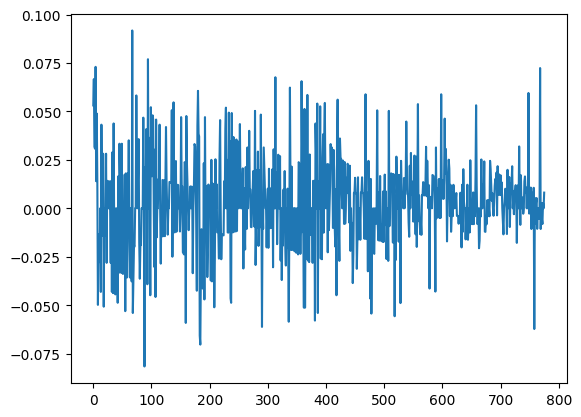

In [ ]:
plt.plot(orig_data['Log_Return'])

In [ ]:
# Filter the dataset for rows where Data_Source is 'Synthetic' and Extreme_Event_After is True
orig_data[(orig_data['Data_Source'] == 'Synthetic') & (orig_data['Extreme_Event_After'] == True)]

,Log_Return,Extreme_Event,Data_Source,Extreme_Event_After
6,0.048921,False,Synthetic,True
8,-0.049868,False,Synthetic,True
18,-0.050801,False,Synthetic,True
86,0.046803,False,Synthetic,True
98,-0.044904,False,Synthetic,True
138,0.054698,False,Synthetic,True
188,-0.041446,False,Synthetic,True
208,-0.051115,False,Synthetic,True
218,0.045532,False,Synthetic,True
238,0.049193,False,Synthetic,True


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Function to prepare data for LSTM model
def prepare_lstm_data(df, n_steps):
    X, y = [], []
    for i in range(len(df) - n_steps):
        X.append(df[i:i + n_steps])
        y.append(df[i + n_steps])
    return np.array(X), np.array(y)

# Number of past days to use for predicting the next value
n_steps = 10

# Selecting the 'Log_Return' column from prova_df for LSTM input
prova_log_returns = orig_data['Log_Return'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
prova_scaled = scaler.fit_transform(prova_log_returns)

# Prepare data for LSTM
X_prova, y_prova = prepare_lstm_data(prova_scaled, n_steps)

# Split the data into training and testing sets
X_train_prova, X_test_prova, y_train_prova, y_test_prova = train_test_split(X_prova, y_prova, test_size=0.01, random_state=42)

X_train_prova.shape, X_test_prova.shape, y_train_prova.shape, y_test_prova.shape


((758, 10, 1), (8, 10, 1), (758, 1), (8, 1))

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [ ]:
X_train_prova.shape

(758, 10, 1)

In [ ]:
input_shape = (10,1)
#input_shape= (X_train_prova[1],X_train_prova[2])
model = create_lstm_model(input_shape)
history = model.fit(X_train_prova, y_train_prova, epochs=100, batch_size=32, validation_data=(X_test_prova, y_test_prova))


Epoch 1/100
24/24 [==============================] - 19s 212ms/step - loss: 0.0551 - val_loss: 0.0073
Epoch 2/100
24/24 [==============================] - 1s 45ms/step - loss: 0.0215 - val_loss: 0.0048
Epoch 3/100
24/24 [==============================] - 1s 42ms/step - loss: 0.0203 - val_loss: 0.0053
Epoch 4/100
24/24 [==============================] - 1s 30ms/step - loss: 0.0193 - val_loss: 0.0050
Epoch 5/100
24/24 [==============================] - 1s 31ms/step - loss: 0.0191 - val_loss: 0.0049
Epoch 6/100
24/24 [==============================] - 1s 29ms/step - loss: 0.0211 - val_loss: 0.0064
Epoch 7/100
24/24 [==============================] - 1s 30ms/step - loss: 0.0209 - val_loss: 0.0069
Epoch 8/100
24/24 [==============================] - 1s 30ms/step - loss: 0.0202 - val_loss: 0.0052
Epoch 9/100
24/24 [==============================] - 1s 31ms/step - loss: 0.0197 - val_loss: 0.0064
Epoch 10/100
24/24 [==============================] - 1s 30ms/step - loss: 0.0194 - val_loss: 0.00

In [ ]:
predicted_prova = model.predict(X_test_prova)

1/1 [==============================] - 1s 1s/step


In [ ]:
from sklearn.metrics import mean_squared_error

# Inverse transform the predictions and actual values to their original scale
predicted_prova_inversed = scaler.inverse_transform(predicted_prova)
y_test_prova_inversed = scaler.inverse_transform(y_test_prova)

# Calculate MSE
mse_prova = mean_squared_error(y_test_prova_inversed, predicted_prova_inversed)
print("Mean Squared Error for Prova dataset:", mse_prova)


Mean Squared Error for Prova dataset: 0.00018211637901057037


In [ ]:
from math import sqrt
rmse = sqrt (mse_prova)
rmse

0.01349505016702681

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test_prova_inversed, predicted_prova_inversed)

0.011045160186394346

In [ ]:
# Generate predictions for the training set
predicted_train_prova = model.predict(X_train_prova)


24/24 [==============================] - 0s 12ms/step


In [ ]:
import matplotlib.pyplot as plt

# Inverse transform the predictions and actual values to their original scale
predicted_train_prova_inv = scaler.inverse_transform(predicted_train_prova)
y_train_prova_inv = scaler.inverse_transform(y_train_prova.reshape(-1, 1))


In [ ]:
# Calculate mean and standard deviation of the actual values
mu = np.mean(y_train_prova_inv)
sigma = np.std(y_train_prova_inv)

# Identify indices of extreme values
extreme_indices = np.where((y_train_prova_inv < (mu - 2 * sigma)) | (y_train_prova_inv > (mu + 2 * sigma)))[0]

# Filter actual and predicted values for extreme values
actual_extreme_values = y_train_prova_inv[extreme_indices]
predicted_extreme_values = predicted_train_prova_inv[extreme_indices]

# Calculate RMSE for extreme values
rmse_extreme = np.sqrt(mean_squared_error(actual_extreme_values, predicted_extreme_values))

print(f'RMSE for Extreme Values: {rmse_extreme}')

RMSE for Extreme Values: 0.05645035148845886


In [ ]:
mean_absolute_error(actual_extreme_values, predicted_extreme_values)

0.05567120294175041

In [ ]:
# Calculate mean and standard deviation of the actual values
mu = np.mean(y_test_prova_inversed)
sigma = np.std(y_test_prova_inversed)
# Identify indices of extreme values
extreme_indices = np.where((y_test_prova_inversed < (mu - 2 * sigma)) | (y_test_prova_inversed > (mu + 2 * sigma)))[0]

# Filter actual and predicted values for extreme values
actual_extreme_values = y_test_prova_inversed[extreme_indices]
predicted_extreme_values = predicted_prova_inversed[extreme_indices]

# Calculate RMSE for extreme values
rmse_extreme = np.sqrt(mean_squared_error(actual_extreme_values, predicted_extreme_values))

print(f'RMSE for Extreme Values: {rmse_extreme}')

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.

In [ ]:
mean_absolute_error(actual_extreme_values, predicted_extreme_values)

# Feature